In [1]:
import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHash

name = 'FNN-Classification-Simple'

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b10','b25','b50','b75'],'fi':['targets','roi','brain']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 10,
}

HASH = getHash(name,[architecture,props])
print(HASH)

FNN-Classification-Simple-sigmoid_100000_1024_512_256_128_0001_CCE_10_1_0_0_1_0_e_e_0_1_0_basal_seg_data_norm_e_k5_b25_t1_0_42_n_native_08_0_05_n


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(884582, 92)
(884582, 3)
validation
(154411, 92)
(154411, 3)
test
(115112, 92)
(115112, 3)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/'+props['space']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASH),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 92)]              0         


 dense (Dense)               (None, 1024)              95232     


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 3)                 387       


Total params: 784643 (2.99 MB)


Trainable params: 784643 (2.99 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASH)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASH), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASH))

Epoch 1/10000


1/9 [==>...........................] - ETA: 33s - loss: 1.1314 - STD: 0.0934 - MAE: 0.4410

2/9 [=====>........................] - ETA: 0s - loss: 1.1078 - STD: 0.0953 - MAE: 0.4365 

3/9 [=========>....................] - ETA: 0s - loss: 1.1081 - STD: 0.1087 - MAE: 0.4332

4/9 [============>.................] - ETA: 0s - loss: 1.1043 - STD: 0.1122 - MAE: 0.4317

5/9 [===============>..............] - ETA: 0s - loss: 1.0988 - STD: 0.1076 - MAE: 0.4317

6/9 [===================>..........] - ETA: 1s - loss: 1.0956 - STD: 0.0981 - MAE: 0.4326

7/9 [======================>.......] - ETA: 1s - loss: 1.0941 - STD: 0.0911 - MAE: 0.4335

8/9 [=========================>....] - ETA: 0s - loss: 1.0933 - STD: 0.0883 - MAE: 0.4339

9/9 [==============================] - ETA: 0s - loss: 1.0920 - STD: 0.0869 - MAE: 0.4340

9/9 [==============================] - 9s 602ms/step - loss: 1.0920 - STD: 0.0869 - MAE: 0.4340 - val_loss: 1.0741 - val_STD: 0.0705 - val_MAE: 0.4342


Epoch 2/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0750 - STD: 0.0707 - MAE: 0.4343

2/9 [=====>........................] - ETA: 0s - loss: 1.0741 - STD: 0.0698 - MAE: 0.4343

3/9 [=========>....................] - ETA: 0s - loss: 1.0746 - STD: 0.0731 - MAE: 0.4339

4/9 [============>.................] - ETA: 0s - loss: 1.0750 - STD: 0.0779 - MAE: 0.4332

5/9 [===============>..............] - ETA: 0s - loss: 1.0753 - STD: 0.0824 - MAE: 0.4324

6/9 [===================>..........] - ETA: 0s - loss: 1.0756 - STD: 0.0855 - MAE: 0.4319

7/9 [======================>.......] - ETA: 0s - loss: 1.0751 - STD: 0.0861 - MAE: 0.4317

8/9 [=========================>....] - ETA: 0s - loss: 1.0743 - STD: 0.0842 - MAE: 0.4318

9/9 [==============================] - ETA: 0s - loss: 1.0739 - STD: 0.0814 - MAE: 0.4322

9/9 [==============================] - 1s 97ms/step - loss: 1.0739 - STD: 0.0814 - MAE: 0.4322 - val_loss: 1.0711 - val_STD: 0.0559 - val_MAE: 0.4353


Epoch 3/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0706 - STD: 0.0564 - MAE: 0.4351

2/9 [=====>........................] - ETA: 0s - loss: 1.0704 - STD: 0.0609 - MAE: 0.4344

3/9 [=========>....................] - ETA: 0s - loss: 1.0705 - STD: 0.0656 - MAE: 0.4339

4/9 [============>.................] - ETA: 0s - loss: 1.0701 - STD: 0.0677 - MAE: 0.4335

5/9 [===============>..............] - ETA: 0s - loss: 1.0693 - STD: 0.0676 - MAE: 0.4333

6/9 [===================>..........] - ETA: 0s - loss: 1.0685 - STD: 0.0674 - MAE: 0.4332

7/9 [======================>.......] - ETA: 0s - loss: 1.0679 - STD: 0.0683 - MAE: 0.4329

8/9 [=========================>....] - ETA: 0s - loss: 1.0671 - STD: 0.0703 - MAE: 0.4324

9/9 [==============================] - ETA: 0s - loss: 1.0664 - STD: 0.0726 - MAE: 0.4318

9/9 [==============================] - 1s 96ms/step - loss: 1.0664 - STD: 0.0726 - MAE: 0.4318 - val_loss: 1.0584 - val_STD: 0.0870 - val_MAE: 0.4276


Epoch 4/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0580 - STD: 0.0885 - MAE: 0.4271

2/9 [=====>........................] - ETA: 0s - loss: 1.0549 - STD: 0.0829 - MAE: 0.4274

3/9 [=========>....................] - ETA: 0s - loss: 1.0532 - STD: 0.0787 - MAE: 0.4277

4/9 [============>.................] - ETA: 0s - loss: 1.0510 - STD: 0.0769 - MAE: 0.4275

5/9 [===============>..............] - ETA: 0s - loss: 1.0490 - STD: 0.0774 - MAE: 0.4269

6/9 [===================>..........] - ETA: 0s - loss: 1.0463 - STD: 0.0775 - MAE: 0.4262

7/9 [======================>.......] - ETA: 0s - loss: 1.0434 - STD: 0.0769 - MAE: 0.4256

8/9 [=========================>....] - ETA: 0s - loss: 1.0400 - STD: 0.0775 - MAE: 0.4247

9/9 [==============================] - ETA: 0s - loss: 1.0364 - STD: 0.0795 - MAE: 0.4235

9/9 [==============================] - 1s 97ms/step - loss: 1.0364 - STD: 0.0795 - MAE: 0.4235 - val_loss: 1.0061 - val_STD: 0.0954 - val_MAE: 0.4136


Epoch 5/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.9968 - STD: 0.1014 - MAE: 0.4099

2/9 [=====>........................] - ETA: 0s - loss: 0.9905 - STD: 0.1044 - MAE: 0.4079

3/9 [=========>....................] - ETA: 0s - loss: 0.9843 - STD: 0.1105 - MAE: 0.4051

4/9 [============>.................] - ETA: 0s - loss: 0.9780 - STD: 0.1166 - MAE: 0.4023

5/9 [===============>..............] - ETA: 0s - loss: 0.9723 - STD: 0.1214 - MAE: 0.3999

6/9 [===================>..........] - ETA: 0s - loss: 0.9676 - STD: 0.1277 - MAE: 0.3972

7/9 [======================>.......] - ETA: 0s - loss: 0.9632 - STD: 0.1323 - MAE: 0.3952

8/9 [=========================>....] - ETA: 0s - loss: 0.9601 - STD: 0.1403 - MAE: 0.3920

9/9 [==============================] - ETA: 0s - loss: 0.9574 - STD: 0.1438 - MAE: 0.3905

9/9 [==============================] - 1s 99ms/step - loss: 0.9574 - STD: 0.1438 - MAE: 0.3905 - val_loss: 0.9653 - val_STD: 0.1894 - val_MAE: 0.3786


Epoch 6/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.9237 - STD: 0.1982 - MAE: 0.3660

2/9 [=====>........................] - ETA: 0s - loss: 0.9288 - STD: 0.2076 - MAE: 0.3631

3/9 [=========>....................] - ETA: 0s - loss: 0.9284 - STD: 0.2036 - MAE: 0.3646

4/9 [============>.................] - ETA: 0s - loss: 0.9277 - STD: 0.2040 - MAE: 0.3642

5/9 [===============>..............] - ETA: 0s - loss: 0.9271 - STD: 0.2081 - MAE: 0.3623

6/9 [===================>..........] - ETA: 0s - loss: 0.9262 - STD: 0.2088 - MAE: 0.3618

7/9 [======================>.......] - ETA: 0s - loss: 0.9252 - STD: 0.2080 - MAE: 0.3619

8/9 [=========================>....] - ETA: 0s - loss: 0.9239 - STD: 0.2086 - MAE: 0.3613

9/9 [==============================] - ETA: 0s - loss: 0.9230 - STD: 0.2096 - MAE: 0.3606

9/9 [==============================] - 1s 97ms/step - loss: 0.9230 - STD: 0.2096 - MAE: 0.3606 - val_loss: 0.9596 - val_STD: 0.2002 - val_MAE: 0.3717


Epoch 7/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.9099 - STD: 0.2033 - MAE: 0.3598

2/9 [=====>........................] - ETA: 0s - loss: 0.9115 - STD: 0.2004 - MAE: 0.3613

3/9 [=========>....................] - ETA: 0s - loss: 0.9100 - STD: 0.2024 - MAE: 0.3602

4/9 [============>.................] - ETA: 0s - loss: 0.9096 - STD: 0.2040 - MAE: 0.3595

5/9 [===============>..............] - ETA: 0s - loss: 0.9084 - STD: 0.2029 - MAE: 0.3596

6/9 [===================>..........] - ETA: 0s - loss: 0.9077 - STD: 0.2013 - MAE: 0.3602

7/9 [======================>.......] - ETA: 0s - loss: 0.9067 - STD: 0.2007 - MAE: 0.3602

8/9 [=========================>....] - ETA: 0s - loss: 0.9066 - STD: 0.2009 - MAE: 0.3601

9/9 [==============================] - ETA: 0s - loss: 0.9062 - STD: 0.2001 - MAE: 0.3603

9/9 [==============================] - 1s 98ms/step - loss: 0.9062 - STD: 0.2001 - MAE: 0.3603 - val_loss: 0.9391 - val_STD: 0.1884 - val_MAE: 0.3726


Epoch 8/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.9003 - STD: 0.1876 - MAE: 0.3640

2/9 [=====>........................] - ETA: 0s - loss: 0.9007 - STD: 0.1893 - MAE: 0.3634

3/9 [=========>....................] - ETA: 0s - loss: 0.9001 - STD: 0.1926 - MAE: 0.3619

4/9 [============>.................] - ETA: 0s - loss: 0.8997 - STD: 0.1941 - MAE: 0.3613

5/9 [===============>..............] - ETA: 0s - loss: 0.8989 - STD: 0.1944 - MAE: 0.3610

6/9 [===================>..........] - ETA: 0s - loss: 0.8981 - STD: 0.1953 - MAE: 0.3605

7/9 [======================>.......] - ETA: 0s - loss: 0.8977 - STD: 0.1973 - MAE: 0.3596

8/9 [=========================>....] - ETA: 0s - loss: 0.8969 - STD: 0.1986 - MAE: 0.3589

9/9 [==============================] - ETA: 0s - loss: 0.8963 - STD: 0.1993 - MAE: 0.3585

9/9 [==============================] - 1s 96ms/step - loss: 0.8963 - STD: 0.1993 - MAE: 0.3585 - val_loss: 0.9292 - val_STD: 0.2096 - val_MAE: 0.3614


Epoch 9/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.8879 - STD: 0.2094 - MAE: 0.3526

2/9 [=====>........................] - ETA: 0s - loss: 0.8889 - STD: 0.2128 - MAE: 0.3514

3/9 [=========>....................] - ETA: 0s - loss: 0.8883 - STD: 0.2120 - MAE: 0.3515

4/9 [============>.................] - ETA: 0s - loss: 0.8873 - STD: 0.2112 - MAE: 0.3517

5/9 [===============>..............] - ETA: 0s - loss: 0.8873 - STD: 0.2118 - MAE: 0.3514

6/9 [===================>..........] - ETA: 0s - loss: 0.8869 - STD: 0.2126 - MAE: 0.3510

7/9 [======================>.......] - ETA: 0s - loss: 0.8858 - STD: 0.2127 - MAE: 0.3507

8/9 [=========================>....] - ETA: 0s - loss: 0.8855 - STD: 0.2128 - MAE: 0.3506

9/9 [==============================] - ETA: 0s - loss: 0.8850 - STD: 0.2135 - MAE: 0.3502

9/9 [==============================] - 1s 97ms/step - loss: 0.8850 - STD: 0.2135 - MAE: 0.3502 - val_loss: 0.9192 - val_STD: 0.2177 - val_MAE: 0.3557


Epoch 10/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.8790 - STD: 0.2158 - MAE: 0.3480

2/9 [=====>........................] - ETA: 0s - loss: 0.8782 - STD: 0.2138 - MAE: 0.3487

3/9 [=========>....................] - ETA: 0s - loss: 0.8778 - STD: 0.2136 - MAE: 0.3487

4/9 [============>.................] - ETA: 0s - loss: 0.8766 - STD: 0.2140 - MAE: 0.3482

5/9 [===============>..............] - ETA: 0s - loss: 0.8762 - STD: 0.2130 - MAE: 0.3486

6/9 [===================>..........] - ETA: 0s - loss: 0.8758 - STD: 0.2125 - MAE: 0.3487

7/9 [======================>.......] - ETA: 0s - loss: 0.8756 - STD: 0.2134 - MAE: 0.3483

8/9 [=========================>....] - ETA: 0s - loss: 0.8749 - STD: 0.2133 - MAE: 0.3482

9/9 [==============================] - ETA: 0s - loss: 0.8742 - STD: 0.2134 - MAE: 0.3480

9/9 [==============================] - 1s 97ms/step - loss: 0.8742 - STD: 0.2134 - MAE: 0.3480 - val_loss: 0.9092 - val_STD: 0.2255 - val_MAE: 0.3502


Epoch 11/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8713 - STD: 0.2204 - MAE: 0.3443

2/9 [=====>........................] - ETA: 0s - loss: 0.8696 - STD: 0.2181 - MAE: 0.3450

3/9 [=========>....................] - ETA: 0s - loss: 0.8682 - STD: 0.2172 - MAE: 0.3451

4/9 [============>.................] - ETA: 0s - loss: 0.8674 - STD: 0.2186 - MAE: 0.3444

5/9 [===============>..............] - ETA: 0s - loss: 0.8672 - STD: 0.2176 - MAE: 0.3447

6/9 [===================>..........] - ETA: 0s - loss: 0.8666 - STD: 0.2184 - MAE: 0.3442

7/9 [======================>.......] - ETA: 0s - loss: 0.8656 - STD: 0.2191 - MAE: 0.3437

8/9 [=========================>....] - ETA: 0s - loss: 0.8650 - STD: 0.2189 - MAE: 0.3437

9/9 [==============================] - ETA: 0s - loss: 0.8641 - STD: 0.2200 - MAE: 0.3430

9/9 [==============================] - 1s 95ms/step - loss: 0.8641 - STD: 0.2200 - MAE: 0.3430 - val_loss: 0.9027 - val_STD: 0.2326 - val_MAE: 0.3453


Epoch 12/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.8575 - STD: 0.2237 - MAE: 0.3400

2/9 [=====>........................] - ETA: 0s - loss: 0.8559 - STD: 0.2251 - MAE: 0.3391

3/9 [=========>....................] - ETA: 0s - loss: 0.8555 - STD: 0.2256 - MAE: 0.3388

4/9 [============>.................] - ETA: 0s - loss: 0.8555 - STD: 0.2259 - MAE: 0.3386

5/9 [===============>..............] - ETA: 0s - loss: 0.8560 - STD: 0.2252 - MAE: 0.3390

6/9 [===================>..........] - ETA: 0s - loss: 0.8555 - STD: 0.2257 - MAE: 0.3387

7/9 [======================>.......] - ETA: 0s - loss: 0.8550 - STD: 0.2251 - MAE: 0.3389

8/9 [=========================>....] - ETA: 0s - loss: 0.8551 - STD: 0.2256 - MAE: 0.3387

9/9 [==============================] - ETA: 0s - loss: 0.8548 - STD: 0.2250 - MAE: 0.3389

9/9 [==============================] - 1s 93ms/step - loss: 0.8548 - STD: 0.2250 - MAE: 0.3389 - val_loss: 0.9061 - val_STD: 0.2519 - val_MAE: 0.3370


Epoch 13/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.8556 - STD: 0.2372 - MAE: 0.3336

2/9 [=====>........................] - ETA: 0s - loss: 0.8547 - STD: 0.2273 - MAE: 0.3379

3/9 [=========>....................] - ETA: 0s - loss: 0.8556 - STD: 0.2331 - MAE: 0.3355

4/9 [============>.................] - ETA: 0s - loss: 0.8543 - STD: 0.2293 - MAE: 0.3369

5/9 [===============>..............] - ETA: 0s - loss: 0.8536 - STD: 0.2294 - MAE: 0.3367

6/9 [===================>..........] - ETA: 0s - loss: 0.8532 - STD: 0.2297 - MAE: 0.3365

7/9 [======================>.......] - ETA: 0s - loss: 0.8522 - STD: 0.2283 - MAE: 0.3369

8/9 [=========================>....] - ETA: 0s - loss: 0.8521 - STD: 0.2294 - MAE: 0.3364

9/9 [==============================] - ETA: 0s - loss: 0.8516 - STD: 0.2289 - MAE: 0.3365

9/9 [==============================] - 1s 98ms/step - loss: 0.8516 - STD: 0.2289 - MAE: 0.3365 - val_loss: 0.8933 - val_STD: 0.2451 - val_MAE: 0.3377


Epoch 14/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.8473 - STD: 0.2280 - MAE: 0.3362

2/9 [=====>........................] - ETA: 0s - loss: 0.8472 - STD: 0.2317 - MAE: 0.3345

3/9 [=========>....................] - ETA: 0s - loss: 0.8462 - STD: 0.2301 - MAE: 0.3350

4/9 [============>.................] - ETA: 0s - loss: 0.8452 - STD: 0.2315 - MAE: 0.3342

5/9 [===============>..............] - ETA: 0s - loss: 0.8453 - STD: 0.2316 - MAE: 0.3342

6/9 [===================>..........] - ETA: 0s - loss: 0.8451 - STD: 0.2309 - MAE: 0.3344

7/9 [======================>.......] - ETA: 0s - loss: 0.8455 - STD: 0.2325 - MAE: 0.3338

8/9 [=========================>....] - ETA: 0s - loss: 0.8455 - STD: 0.2315 - MAE: 0.3342

9/9 [==============================] - ETA: 0s - loss: 0.8451 - STD: 0.2325 - MAE: 0.3337

9/9 [==============================] - 1s 96ms/step - loss: 0.8451 - STD: 0.2325 - MAE: 0.3337 - val_loss: 0.8966 - val_STD: 0.2558 - val_MAE: 0.3332


Epoch 15/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.8407 - STD: 0.2362 - MAE: 0.3311

2/9 [=====>........................] - ETA: 0s - loss: 0.8419 - STD: 0.2316 - MAE: 0.3335

3/9 [=========>....................] - ETA: 0s - loss: 0.8438 - STD: 0.2351 - MAE: 0.3323

4/9 [============>.................] - ETA: 0s - loss: 0.8433 - STD: 0.2339 - MAE: 0.3328

5/9 [===============>..............] - ETA: 0s - loss: 0.8430 - STD: 0.2326 - MAE: 0.3333

6/9 [===================>..........] - ETA: 0s - loss: 0.8425 - STD: 0.2342 - MAE: 0.3325

7/9 [======================>.......] - ETA: 0s - loss: 0.8424 - STD: 0.2334 - MAE: 0.3328

8/9 [=========================>....] - ETA: 0s - loss: 0.8419 - STD: 0.2334 - MAE: 0.3327

9/9 [==============================] - ETA: 0s - loss: 0.8422 - STD: 0.2345 - MAE: 0.3323

9/9 [==============================] - 1s 96ms/step - loss: 0.8422 - STD: 0.2345 - MAE: 0.3323 - val_loss: 0.8863 - val_STD: 0.2458 - val_MAE: 0.3361


Epoch 16/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8390 - STD: 0.2280 - MAE: 0.3346

2/9 [=====>........................] - ETA: 0s - loss: 0.8399 - STD: 0.2323 - MAE: 0.3328

3/9 [=========>....................] - ETA: 0s - loss: 0.8397 - STD: 0.2340 - MAE: 0.3320

4/9 [============>.................] - ETA: 0s - loss: 0.8395 - STD: 0.2328 - MAE: 0.3326

5/9 [===============>..............] - ETA: 0s - loss: 0.8398 - STD: 0.2340 - MAE: 0.3321

6/9 [===================>..........] - ETA: 0s - loss: 0.8393 - STD: 0.2350 - MAE: 0.3315

7/9 [======================>.......] - ETA: 0s - loss: 0.8395 - STD: 0.2348 - MAE: 0.3317

8/9 [=========================>....] - ETA: 0s - loss: 0.8392 - STD: 0.2357 - MAE: 0.3312

9/9 [==============================] - ETA: 0s - loss: 0.8392 - STD: 0.2355 - MAE: 0.3313

9/9 [==============================] - 1s 93ms/step - loss: 0.8392 - STD: 0.2355 - MAE: 0.3313 - val_loss: 0.8888 - val_STD: 0.2543 - val_MAE: 0.3324


Epoch 17/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.8366 - STD: 0.2347 - MAE: 0.3311

2/9 [=====>........................] - ETA: 0s - loss: 0.8362 - STD: 0.2366 - MAE: 0.3302

3/9 [=========>....................] - ETA: 0s - loss: 0.8358 - STD: 0.2360 - MAE: 0.3303

4/9 [============>.................] - ETA: 0s - loss: 0.8368 - STD: 0.2361 - MAE: 0.3305

5/9 [===============>..............] - ETA: 0s - loss: 0.8362 - STD: 0.2370 - MAE: 0.3300

6/9 [===================>..........] - ETA: 0s - loss: 0.8360 - STD: 0.2377 - MAE: 0.3296

7/9 [======================>.......] - ETA: 0s - loss: 0.8362 - STD: 0.2371 - MAE: 0.3299

8/9 [=========================>....] - ETA: 0s - loss: 0.8363 - STD: 0.2371 - MAE: 0.3300

9/9 [==============================] - ETA: 0s - loss: 0.8363 - STD: 0.2372 - MAE: 0.3300

9/9 [==============================] - 1s 96ms/step - loss: 0.8363 - STD: 0.2372 - MAE: 0.3300 - val_loss: 0.8835 - val_STD: 0.2511 - val_MAE: 0.3330


Epoch 18/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.8356 - STD: 0.2336 - MAE: 0.3316

2/9 [=====>........................] - ETA: 0s - loss: 0.8360 - STD: 0.2388 - MAE: 0.3292

3/9 [=========>....................] - ETA: 0s - loss: 0.8349 - STD: 0.2385 - MAE: 0.3291

4/9 [============>.................] - ETA: 0s - loss: 0.8344 - STD: 0.2381 - MAE: 0.3292

5/9 [===============>..............] - ETA: 0s - loss: 0.8349 - STD: 0.2391 - MAE: 0.3289

6/9 [===================>..........] - ETA: 0s - loss: 0.8353 - STD: 0.2376 - MAE: 0.3296

7/9 [======================>.......] - ETA: 0s - loss: 0.8351 - STD: 0.2383 - MAE: 0.3293

8/9 [=========================>....] - ETA: 0s - loss: 0.8351 - STD: 0.2383 - MAE: 0.3293

9/9 [==============================] - ETA: 0s - loss: 0.8351 - STD: 0.2379 - MAE: 0.3294

9/9 [==============================] - 1s 93ms/step - loss: 0.8351 - STD: 0.2379 - MAE: 0.3294 - val_loss: 0.8916 - val_STD: 0.2645 - val_MAE: 0.3280


Epoch 19/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.8349 - STD: 0.2457 - MAE: 0.3258

2/9 [=====>........................] - ETA: 0s - loss: 0.8337 - STD: 0.2419 - MAE: 0.3274

3/9 [=========>....................] - ETA: 0s - loss: 0.8337 - STD: 0.2398 - MAE: 0.3283

4/9 [============>.................] - ETA: 0s - loss: 0.8341 - STD: 0.2409 - MAE: 0.3279

5/9 [===============>..............] - ETA: 0s - loss: 0.8341 - STD: 0.2395 - MAE: 0.3285

6/9 [===================>..........] - ETA: 0s - loss: 0.8338 - STD: 0.2401 - MAE: 0.3282

7/9 [======================>.......] - ETA: 0s - loss: 0.8335 - STD: 0.2405 - MAE: 0.3279

8/9 [=========================>....] - ETA: 0s - loss: 0.8333 - STD: 0.2399 - MAE: 0.3282

9/9 [==============================] - ETA: 0s - loss: 0.8329 - STD: 0.2403 - MAE: 0.3279

9/9 [==============================] - 1s 99ms/step - loss: 0.8329 - STD: 0.2403 - MAE: 0.3279 - val_loss: 0.8806 - val_STD: 0.2538 - val_MAE: 0.3312


Epoch 20/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8322 - STD: 0.2373 - MAE: 0.3292

2/9 [=====>........................] - ETA: 0s - loss: 0.8332 - STD: 0.2365 - MAE: 0.3298

3/9 [=========>....................] - ETA: 0s - loss: 0.8323 - STD: 0.2385 - MAE: 0.3287

4/9 [============>.................] - ETA: 0s - loss: 0.8320 - STD: 0.2388 - MAE: 0.3285

5/9 [===============>..............] - ETA: 0s - loss: 0.8321 - STD: 0.2393 - MAE: 0.3282

6/9 [===================>..........] - ETA: 0s - loss: 0.8319 - STD: 0.2399 - MAE: 0.3279

7/9 [======================>.......] - ETA: 0s - loss: 0.8314 - STD: 0.2393 - MAE: 0.3281

8/9 [=========================>....] - ETA: 0s - loss: 0.8306 - STD: 0.2396 - MAE: 0.3278

9/9 [==============================] - ETA: 0s - loss: 0.8303 - STD: 0.2400 - MAE: 0.3275

9/9 [==============================] - 1s 98ms/step - loss: 0.8303 - STD: 0.2400 - MAE: 0.3275 - val_loss: 0.8784 - val_STD: 0.2553 - val_MAE: 0.3300


Epoch 21/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8300 - STD: 0.2389 - MAE: 0.3280

2/9 [=====>........................] - ETA: 0s - loss: 0.8279 - STD: 0.2426 - MAE: 0.3258

3/9 [=========>....................] - ETA: 0s - loss: 0.8279 - STD: 0.2424 - MAE: 0.3259

4/9 [============>.................] - ETA: 0s - loss: 0.8290 - STD: 0.2409 - MAE: 0.3268

5/9 [===============>..............] - ETA: 0s - loss: 0.8293 - STD: 0.2421 - MAE: 0.3263

6/9 [===================>..........] - ETA: 0s - loss: 0.8296 - STD: 0.2414 - MAE: 0.3267

7/9 [======================>.......] - ETA: 0s - loss: 0.8291 - STD: 0.2413 - MAE: 0.3267

8/9 [=========================>....] - ETA: 0s - loss: 0.8287 - STD: 0.2422 - MAE: 0.3262

9/9 [==============================] - ETA: 0s - loss: 0.8284 - STD: 0.2413 - MAE: 0.3265

9/9 [==============================] - 1s 94ms/step - loss: 0.8284 - STD: 0.2413 - MAE: 0.3265 - val_loss: 0.8826 - val_STD: 0.2622 - val_MAE: 0.3273


Epoch 22/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8259 - STD: 0.2462 - MAE: 0.3236

2/9 [=====>........................] - ETA: 0s - loss: 0.8249 - STD: 0.2441 - MAE: 0.3245

3/9 [=========>....................] - ETA: 0s - loss: 0.8265 - STD: 0.2414 - MAE: 0.3261

4/9 [============>.................] - ETA: 0s - loss: 0.8273 - STD: 0.2436 - MAE: 0.3252

5/9 [===============>..............] - ETA: 0s - loss: 0.8267 - STD: 0.2422 - MAE: 0.3257

6/9 [===================>..........] - ETA: 0s - loss: 0.8263 - STD: 0.2424 - MAE: 0.3256

7/9 [======================>.......] - ETA: 0s - loss: 0.8262 - STD: 0.2432 - MAE: 0.3252

8/9 [=========================>....] - ETA: 0s - loss: 0.8262 - STD: 0.2423 - MAE: 0.3256

9/9 [==============================] - ETA: 0s - loss: 0.8259 - STD: 0.2432 - MAE: 0.3251

9/9 [==============================] - 1s 95ms/step - loss: 0.8259 - STD: 0.2432 - MAE: 0.3251 - val_loss: 0.8734 - val_STD: 0.2547 - val_MAE: 0.3292


Epoch 23/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.8194 - STD: 0.2410 - MAE: 0.3247

2/9 [=====>........................] - ETA: 0s - loss: 0.8214 - STD: 0.2401 - MAE: 0.3256

3/9 [=========>....................] - ETA: 0s - loss: 0.8228 - STD: 0.2435 - MAE: 0.3243

4/9 [============>.................] - ETA: 0s - loss: 0.8228 - STD: 0.2418 - MAE: 0.3251

5/9 [===============>..............] - ETA: 0s - loss: 0.8226 - STD: 0.2422 - MAE: 0.3249

6/9 [===================>..........] - ETA: 0s - loss: 0.8227 - STD: 0.2428 - MAE: 0.3246

7/9 [======================>.......] - ETA: 0s - loss: 0.8227 - STD: 0.2423 - MAE: 0.3249

8/9 [=========================>....] - ETA: 0s - loss: 0.8225 - STD: 0.2434 - MAE: 0.3243

9/9 [==============================] - ETA: 0s - loss: 0.8221 - STD: 0.2426 - MAE: 0.3246

9/9 [==============================] - 1s 99ms/step - loss: 0.8221 - STD: 0.2426 - MAE: 0.3246 - val_loss: 0.8704 - val_STD: 0.2559 - val_MAE: 0.3280


Epoch 24/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.8219 - STD: 0.2432 - MAE: 0.3244

2/9 [=====>........................] - ETA: 0s - loss: 0.8192 - STD: 0.2477 - MAE: 0.3216

3/9 [=========>....................] - ETA: 0s - loss: 0.8199 - STD: 0.2442 - MAE: 0.3234

4/9 [============>.................] - ETA: 0s - loss: 0.8187 - STD: 0.2451 - MAE: 0.3227

5/9 [===============>..............] - ETA: 0s - loss: 0.8183 - STD: 0.2453 - MAE: 0.3225

6/9 [===================>..........] - ETA: 0s - loss: 0.8181 - STD: 0.2450 - MAE: 0.3226

7/9 [======================>.......] - ETA: 0s - loss: 0.8179 - STD: 0.2460 - MAE: 0.3221

8/9 [=========================>....] - ETA: 0s - loss: 0.8177 - STD: 0.2451 - MAE: 0.3224

9/9 [==============================] - ETA: 0s - loss: 0.8173 - STD: 0.2454 - MAE: 0.3222

9/9 [==============================] - 1s 92ms/step - loss: 0.8173 - STD: 0.2454 - MAE: 0.3222 - val_loss: 0.8783 - val_STD: 0.2672 - val_MAE: 0.3234


Epoch 25/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.8144 - STD: 0.2562 - MAE: 0.3162

2/9 [=====>........................] - ETA: 0s - loss: 0.8161 - STD: 0.2465 - MAE: 0.3214

3/9 [=========>....................] - ETA: 0s - loss: 0.8155 - STD: 0.2468 - MAE: 0.3211

4/9 [============>.................] - ETA: 0s - loss: 0.8144 - STD: 0.2482 - MAE: 0.3202

5/9 [===============>..............] - ETA: 0s - loss: 0.8147 - STD: 0.2467 - MAE: 0.3210

6/9 [===================>..........] - ETA: 0s - loss: 0.8150 - STD: 0.2469 - MAE: 0.3210

7/9 [======================>.......] - ETA: 0s - loss: 0.8141 - STD: 0.2472 - MAE: 0.3206

8/9 [=========================>....] - ETA: 0s - loss: 0.8134 - STD: 0.2472 - MAE: 0.3205

9/9 [==============================] - ETA: 0s - loss: 0.8133 - STD: 0.2471 - MAE: 0.3205

9/9 [==============================] - 1s 97ms/step - loss: 0.8133 - STD: 0.2471 - MAE: 0.3205 - val_loss: 0.8666 - val_STD: 0.2585 - val_MAE: 0.3256


Epoch 26/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.8075 - STD: 0.2502 - MAE: 0.3179

2/9 [=====>........................] - ETA: 0s - loss: 0.8096 - STD: 0.2517 - MAE: 0.3176

3/9 [=========>....................] - ETA: 0s - loss: 0.8085 - STD: 0.2496 - MAE: 0.3183

4/9 [============>.................] - ETA: 0s - loss: 0.8081 - STD: 0.2495 - MAE: 0.3183

5/9 [===============>..............] - ETA: 0s - loss: 0.8082 - STD: 0.2508 - MAE: 0.3177

6/9 [===================>..........] - ETA: 0s - loss: 0.8085 - STD: 0.2498 - MAE: 0.3182

7/9 [======================>.......] - ETA: 0s - loss: 0.8080 - STD: 0.2500 - MAE: 0.3180

8/9 [=========================>....] - ETA: 0s - loss: 0.8083 - STD: 0.2512 - MAE: 0.3174

9/9 [==============================] - ETA: 0s - loss: 0.8084 - STD: 0.2503 - MAE: 0.3179

9/9 [==============================] - 1s 94ms/step - loss: 0.8084 - STD: 0.2503 - MAE: 0.3179 - val_loss: 0.8701 - val_STD: 0.2602 - val_MAE: 0.3250


Epoch 27/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.8074 - STD: 0.2512 - MAE: 0.3172

2/9 [=====>........................] - ETA: 0s - loss: 0.8077 - STD: 0.2548 - MAE: 0.3156

3/9 [=========>....................] - ETA: 0s - loss: 0.8075 - STD: 0.2515 - MAE: 0.3171

4/9 [============>.................] - ETA: 0s - loss: 0.8068 - STD: 0.2508 - MAE: 0.3173

5/9 [===============>..............] - ETA: 0s - loss: 0.8068 - STD: 0.2521 - MAE: 0.3167

6/9 [===================>..........] - ETA: 0s - loss: 0.8063 - STD: 0.2512 - MAE: 0.3170

7/9 [======================>.......] - ETA: 0s - loss: 0.8064 - STD: 0.2513 - MAE: 0.3170

8/9 [=========================>....] - ETA: 0s - loss: 0.8063 - STD: 0.2520 - MAE: 0.3166

9/9 [==============================] - ETA: 0s - loss: 0.8060 - STD: 0.2520 - MAE: 0.3165

9/9 [==============================] - 1s 93ms/step - loss: 0.8060 - STD: 0.2520 - MAE: 0.3165 - val_loss: 0.8762 - val_STD: 0.2603 - val_MAE: 0.3260


Epoch 28/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.8075 - STD: 0.2509 - MAE: 0.3174

2/9 [=====>........................] - ETA: 0s - loss: 0.8059 - STD: 0.2543 - MAE: 0.3154

3/9 [=========>....................] - ETA: 0s - loss: 0.8053 - STD: 0.2542 - MAE: 0.3153

4/9 [============>.................] - ETA: 0s - loss: 0.8048 - STD: 0.2532 - MAE: 0.3157

5/9 [===============>..............] - ETA: 0s - loss: 0.8044 - STD: 0.2537 - MAE: 0.3154

6/9 [===================>..........] - ETA: 0s - loss: 0.8046 - STD: 0.2536 - MAE: 0.3155

7/9 [======================>.......] - ETA: 0s - loss: 0.8049 - STD: 0.2529 - MAE: 0.3159

8/9 [=========================>....] - ETA: 0s - loss: 0.8047 - STD: 0.2531 - MAE: 0.3158

9/9 [==============================] - ETA: 0s - loss: 0.8039 - STD: 0.2529 - MAE: 0.3157

9/9 [==============================] - 1s 97ms/step - loss: 0.8039 - STD: 0.2529 - MAE: 0.3157 - val_loss: 0.8660 - val_STD: 0.2598 - val_MAE: 0.3246


Epoch 29/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.8051 - STD: 0.2505 - MAE: 0.3174

2/9 [=====>........................] - ETA: 0s - loss: 0.8028 - STD: 0.2520 - MAE: 0.3160

3/9 [=========>....................] - ETA: 0s - loss: 0.8011 - STD: 0.2531 - MAE: 0.3151

4/9 [============>.................] - ETA: 0s - loss: 0.8008 - STD: 0.2531 - MAE: 0.3150

5/9 [===============>..............] - ETA: 0s - loss: 0.8008 - STD: 0.2538 - MAE: 0.3147

6/9 [===================>..........] - ETA: 0s - loss: 0.8013 - STD: 0.2539 - MAE: 0.3147

7/9 [======================>.......] - ETA: 0s - loss: 0.8015 - STD: 0.2538 - MAE: 0.3148

8/9 [=========================>....] - ETA: 0s - loss: 0.8017 - STD: 0.2539 - MAE: 0.3148

9/9 [==============================] - ETA: 0s - loss: 0.8014 - STD: 0.2540 - MAE: 0.3147

9/9 [==============================] - 1s 93ms/step - loss: 0.8014 - STD: 0.2540 - MAE: 0.3147 - val_loss: 0.8736 - val_STD: 0.2635 - val_MAE: 0.3239


Epoch 30/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.8029 - STD: 0.2534 - MAE: 0.3153

2/9 [=====>........................] - ETA: 0s - loss: 0.8024 - STD: 0.2534 - MAE: 0.3152

3/9 [=========>....................] - ETA: 0s - loss: 0.8022 - STD: 0.2537 - MAE: 0.3150

4/9 [============>.................] - ETA: 0s - loss: 0.8022 - STD: 0.2533 - MAE: 0.3152

5/9 [===============>..............] - ETA: 0s - loss: 0.8013 - STD: 0.2536 - MAE: 0.3150

6/9 [===================>..........] - ETA: 0s - loss: 0.8012 - STD: 0.2540 - MAE: 0.3147

7/9 [======================>.......] - ETA: 0s - loss: 0.8009 - STD: 0.2540 - MAE: 0.3146

8/9 [=========================>....] - ETA: 0s - loss: 0.8005 - STD: 0.2539 - MAE: 0.3146

9/9 [==============================] - ETA: 0s - loss: 0.8004 - STD: 0.2543 - MAE: 0.3144

9/9 [==============================] - 1s 95ms/step - loss: 0.8004 - STD: 0.2543 - MAE: 0.3144 - val_loss: 0.8618 - val_STD: 0.2615 - val_MAE: 0.3230


Epoch 31/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.8046 - STD: 0.2525 - MAE: 0.3163

2/9 [=====>........................] - ETA: 0s - loss: 0.8047 - STD: 0.2527 - MAE: 0.3161

3/9 [=========>....................] - ETA: 0s - loss: 0.8043 - STD: 0.2550 - MAE: 0.3149

4/9 [============>.................] - ETA: 0s - loss: 0.8025 - STD: 0.2545 - MAE: 0.3148

5/9 [===============>..............] - ETA: 0s - loss: 0.8023 - STD: 0.2541 - MAE: 0.3149

6/9 [===================>..........] - ETA: 0s - loss: 0.8023 - STD: 0.2546 - MAE: 0.3147

7/9 [======================>.......] - ETA: 0s - loss: 0.8012 - STD: 0.2548 - MAE: 0.3143

8/9 [=========================>....] - ETA: 0s - loss: 0.8007 - STD: 0.2544 - MAE: 0.3144

9/9 [==============================] - ETA: 0s - loss: 0.8006 - STD: 0.2546 - MAE: 0.3143

9/9 [==============================] - 1s 92ms/step - loss: 0.8006 - STD: 0.2546 - MAE: 0.3143 - val_loss: 0.8711 - val_STD: 0.2691 - val_MAE: 0.3204


Epoch 32/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7994 - STD: 0.2585 - MAE: 0.3121

2/9 [=====>........................] - ETA: 0s - loss: 0.7989 - STD: 0.2546 - MAE: 0.3140

3/9 [=========>....................] - ETA: 0s - loss: 0.7994 - STD: 0.2550 - MAE: 0.3138

4/9 [============>.................] - ETA: 0s - loss: 0.7984 - STD: 0.2561 - MAE: 0.3131

5/9 [===============>..............] - ETA: 0s - loss: 0.7984 - STD: 0.2548 - MAE: 0.3138

6/9 [===================>..........] - ETA: 0s - loss: 0.7980 - STD: 0.2551 - MAE: 0.3136

7/9 [======================>.......] - ETA: 0s - loss: 0.7983 - STD: 0.2558 - MAE: 0.3133

8/9 [=========================>....] - ETA: 0s - loss: 0.7984 - STD: 0.2549 - MAE: 0.3138

9/9 [==============================] - ETA: 0s - loss: 0.7977 - STD: 0.2552 - MAE: 0.3135

9/9 [==============================] - 1s 94ms/step - loss: 0.7977 - STD: 0.2552 - MAE: 0.3135 - val_loss: 0.8647 - val_STD: 0.2700 - val_MAE: 0.3189


Epoch 33/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7932 - STD: 0.2592 - MAE: 0.3106

2/9 [=====>........................] - ETA: 0s - loss: 0.7954 - STD: 0.2543 - MAE: 0.3135

3/9 [=========>....................] - ETA: 0s - loss: 0.7960 - STD: 0.2551 - MAE: 0.3132

4/9 [============>.................] - ETA: 0s - loss: 0.7956 - STD: 0.2566 - MAE: 0.3123

5/9 [===============>..............] - ETA: 0s - loss: 0.7955 - STD: 0.2550 - MAE: 0.3131

6/9 [===================>..........] - ETA: 0s - loss: 0.7953 - STD: 0.2554 - MAE: 0.3129

7/9 [======================>.......] - ETA: 0s - loss: 0.7955 - STD: 0.2562 - MAE: 0.3125

8/9 [=========================>....] - ETA: 0s - loss: 0.7954 - STD: 0.2553 - MAE: 0.3130

9/9 [==============================] - ETA: 0s - loss: 0.7952 - STD: 0.2558 - MAE: 0.3127

9/9 [==============================] - 1s 95ms/step - loss: 0.7952 - STD: 0.2558 - MAE: 0.3127 - val_loss: 0.8627 - val_STD: 0.2722 - val_MAE: 0.3173


Epoch 34/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7933 - STD: 0.2609 - MAE: 0.3098

2/9 [=====>........................] - ETA: 0s - loss: 0.7938 - STD: 0.2559 - MAE: 0.3123

3/9 [=========>....................] - ETA: 0s - loss: 0.7942 - STD: 0.2562 - MAE: 0.3123

4/9 [============>.................] - ETA: 0s - loss: 0.7932 - STD: 0.2570 - MAE: 0.3117

5/9 [===============>..............] - ETA: 0s - loss: 0.7932 - STD: 0.2561 - MAE: 0.3121

6/9 [===================>..........] - ETA: 0s - loss: 0.7932 - STD: 0.2563 - MAE: 0.3121

7/9 [======================>.......] - ETA: 0s - loss: 0.7928 - STD: 0.2567 - MAE: 0.3118

8/9 [=========================>....] - ETA: 0s - loss: 0.7931 - STD: 0.2562 - MAE: 0.3121

9/9 [==============================] - ETA: 0s - loss: 0.7925 - STD: 0.2564 - MAE: 0.3119

9/9 [==============================] - 1s 100ms/step - loss: 0.7925 - STD: 0.2564 - MAE: 0.3119 - val_loss: 0.8578 - val_STD: 0.2723 - val_MAE: 0.3164


Epoch 35/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7902 - STD: 0.2619 - MAE: 0.3086

2/9 [=====>........................] - ETA: 0s - loss: 0.7908 - STD: 0.2586 - MAE: 0.3105

3/9 [=========>....................] - ETA: 0s - loss: 0.7902 - STD: 0.2588 - MAE: 0.3102

4/9 [============>.................] - ETA: 0s - loss: 0.7907 - STD: 0.2592 - MAE: 0.3101

5/9 [===============>..............] - ETA: 0s - loss: 0.7910 - STD: 0.2584 - MAE: 0.3106

6/9 [===================>..........] - ETA: 0s - loss: 0.7911 - STD: 0.2586 - MAE: 0.3105

7/9 [======================>.......] - ETA: 0s - loss: 0.7913 - STD: 0.2584 - MAE: 0.3106

8/9 [=========================>....] - ETA: 0s - loss: 0.7908 - STD: 0.2583 - MAE: 0.3106

9/9 [==============================] - ETA: 0s - loss: 0.7908 - STD: 0.2580 - MAE: 0.3107

9/9 [==============================] - 1s 97ms/step - loss: 0.7908 - STD: 0.2580 - MAE: 0.3107 - val_loss: 0.8577 - val_STD: 0.2694 - val_MAE: 0.3179


Epoch 36/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7919 - STD: 0.2569 - MAE: 0.3115

2/9 [=====>........................] - ETA: 0s - loss: 0.7906 - STD: 0.2567 - MAE: 0.3114

3/9 [=========>....................] - ETA: 0s - loss: 0.7904 - STD: 0.2566 - MAE: 0.3114

4/9 [============>.................] - ETA: 0s - loss: 0.7903 - STD: 0.2574 - MAE: 0.3110

5/9 [===============>..............] - ETA: 0s - loss: 0.7902 - STD: 0.2571 - MAE: 0.3111

6/9 [===================>..........] - ETA: 0s - loss: 0.7900 - STD: 0.2579 - MAE: 0.3107

7/9 [======================>.......] - ETA: 0s - loss: 0.7895 - STD: 0.2578 - MAE: 0.3106

8/9 [=========================>....] - ETA: 0s - loss: 0.7892 - STD: 0.2578 - MAE: 0.3106

9/9 [==============================] - ETA: 0s - loss: 0.7889 - STD: 0.2582 - MAE: 0.3103

9/9 [==============================] - 1s 92ms/step - loss: 0.7889 - STD: 0.2582 - MAE: 0.3103 - val_loss: 0.8581 - val_STD: 0.2677 - val_MAE: 0.3189


Epoch 37/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7905 - STD: 0.2551 - MAE: 0.3123

2/9 [=====>........................] - ETA: 0s - loss: 0.7901 - STD: 0.2586 - MAE: 0.3104

3/9 [=========>....................] - ETA: 0s - loss: 0.7904 - STD: 0.2578 - MAE: 0.3108

4/9 [============>.................] - ETA: 0s - loss: 0.7895 - STD: 0.2577 - MAE: 0.3108

5/9 [===============>..............] - ETA: 0s - loss: 0.7893 - STD: 0.2584 - MAE: 0.3104

6/9 [===================>..........] - ETA: 0s - loss: 0.7885 - STD: 0.2578 - MAE: 0.3105

7/9 [======================>.......] - ETA: 0s - loss: 0.7877 - STD: 0.2581 - MAE: 0.3102

8/9 [=========================>....] - ETA: 0s - loss: 0.7875 - STD: 0.2583 - MAE: 0.3101

9/9 [==============================] - ETA: 0s - loss: 0.7871 - STD: 0.2580 - MAE: 0.3102

9/9 [==============================] - 1s 96ms/step - loss: 0.7871 - STD: 0.2580 - MAE: 0.3102 - val_loss: 0.8542 - val_STD: 0.2768 - val_MAE: 0.3134


Epoch 38/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7861 - STD: 0.2643 - MAE: 0.3069

2/9 [=====>........................] - ETA: 0s - loss: 0.7856 - STD: 0.2606 - MAE: 0.3086

3/9 [=========>....................] - ETA: 0s - loss: 0.7854 - STD: 0.2598 - MAE: 0.3090

4/9 [============>.................] - ETA: 0s - loss: 0.7855 - STD: 0.2604 - MAE: 0.3087

5/9 [===============>..............] - ETA: 0s - loss: 0.7848 - STD: 0.2600 - MAE: 0.3087

6/9 [===================>..........] - ETA: 0s - loss: 0.7852 - STD: 0.2596 - MAE: 0.3090

7/9 [======================>.......] - ETA: 0s - loss: 0.7853 - STD: 0.2599 - MAE: 0.3089

8/9 [=========================>....] - ETA: 0s - loss: 0.7849 - STD: 0.2596 - MAE: 0.3089

9/9 [==============================] - ETA: 0s - loss: 0.7853 - STD: 0.2595 - MAE: 0.3091

9/9 [==============================] - 1s 95ms/step - loss: 0.7853 - STD: 0.2595 - MAE: 0.3091 - val_loss: 0.8538 - val_STD: 0.2757 - val_MAE: 0.3140


Epoch 39/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7952 - STD: 0.2646 - MAE: 0.3085

2/9 [=====>........................] - ETA: 0s - loss: 0.7992 - STD: 0.2613 - MAE: 0.3109

3/9 [=========>....................] - ETA: 0s - loss: 0.7979 - STD: 0.2632 - MAE: 0.3097

4/9 [============>.................] - ETA: 0s - loss: 0.7941 - STD: 0.2627 - MAE: 0.3092

5/9 [===============>..............] - ETA: 0s - loss: 0.7920 - STD: 0.2616 - MAE: 0.3093

6/9 [===================>..........] - ETA: 0s - loss: 0.7920 - STD: 0.2625 - MAE: 0.3089

7/9 [======================>.......] - ETA: 0s - loss: 0.7917 - STD: 0.2622 - MAE: 0.3090

8/9 [=========================>....] - ETA: 0s - loss: 0.7906 - STD: 0.2615 - MAE: 0.3091

9/9 [==============================] - ETA: 0s - loss: 0.7903 - STD: 0.2617 - MAE: 0.3090

9/9 [==============================] - 1s 92ms/step - loss: 0.7903 - STD: 0.2617 - MAE: 0.3090 - val_loss: 0.8591 - val_STD: 0.2740 - val_MAE: 0.3158


Epoch 40/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7891 - STD: 0.2598 - MAE: 0.3096

2/9 [=====>........................] - ETA: 0s - loss: 0.7869 - STD: 0.2561 - MAE: 0.3111

3/9 [=========>....................] - ETA: 0s - loss: 0.7863 - STD: 0.2585 - MAE: 0.3098

4/9 [============>.................] - ETA: 0s - loss: 0.7864 - STD: 0.2581 - MAE: 0.3100

5/9 [===============>..............] - ETA: 0s - loss: 0.7855 - STD: 0.2575 - MAE: 0.3102

6/9 [===================>..........] - ETA: 0s - loss: 0.7855 - STD: 0.2587 - MAE: 0.3095

7/9 [======================>.......] - ETA: 0s - loss: 0.7854 - STD: 0.2583 - MAE: 0.3097

8/9 [=========================>....] - ETA: 0s - loss: 0.7850 - STD: 0.2583 - MAE: 0.3097

9/9 [==============================] - ETA: 0s - loss: 0.7847 - STD: 0.2590 - MAE: 0.3092

9/9 [==============================] - 1s 96ms/step - loss: 0.7847 - STD: 0.2590 - MAE: 0.3092 - val_loss: 0.8473 - val_STD: 0.2703 - val_MAE: 0.3158


Epoch 41/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7840 - STD: 0.2562 - MAE: 0.3105

2/9 [=====>........................] - ETA: 0s - loss: 0.7825 - STD: 0.2598 - MAE: 0.3084

3/9 [=========>....................] - ETA: 0s - loss: 0.7807 - STD: 0.2600 - MAE: 0.3079

4/9 [============>.................] - ETA: 0s - loss: 0.7806 - STD: 0.2592 - MAE: 0.3083

5/9 [===============>..............] - ETA: 0s - loss: 0.7807 - STD: 0.2597 - MAE: 0.3081

6/9 [===================>..........] - ETA: 0s - loss: 0.7803 - STD: 0.2597 - MAE: 0.3080

7/9 [======================>.......] - ETA: 0s - loss: 0.7804 - STD: 0.2597 - MAE: 0.3080

8/9 [=========================>....] - ETA: 0s - loss: 0.7800 - STD: 0.2601 - MAE: 0.3078

9/9 [==============================] - ETA: 0s - loss: 0.7804 - STD: 0.2600 - MAE: 0.3079

9/9 [==============================] - 1s 100ms/step - loss: 0.7804 - STD: 0.2600 - MAE: 0.3079 - val_loss: 0.8440 - val_STD: 0.2752 - val_MAE: 0.3125


Epoch 42/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7799 - STD: 0.2606 - MAE: 0.3076

2/9 [=====>........................] - ETA: 0s - loss: 0.7791 - STD: 0.2624 - MAE: 0.3065

3/9 [=========>....................] - ETA: 0s - loss: 0.7790 - STD: 0.2608 - MAE: 0.3073

4/9 [============>.................] - ETA: 0s - loss: 0.7796 - STD: 0.2616 - MAE: 0.3070

5/9 [===============>..............] - ETA: 0s - loss: 0.7786 - STD: 0.2613 - MAE: 0.3069

6/9 [===================>..........] - ETA: 0s - loss: 0.7781 - STD: 0.2613 - MAE: 0.3069

7/9 [======================>.......] - ETA: 0s - loss: 0.7778 - STD: 0.2614 - MAE: 0.3067

8/9 [=========================>....] - ETA: 0s - loss: 0.7783 - STD: 0.2613 - MAE: 0.3069

9/9 [==============================] - ETA: 0s - loss: 0.7782 - STD: 0.2614 - MAE: 0.3068

9/9 [==============================] - 1s 98ms/step - loss: 0.7782 - STD: 0.2614 - MAE: 0.3068 - val_loss: 0.8421 - val_STD: 0.2772 - val_MAE: 0.3112


Epoch 43/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7776 - STD: 0.2626 - MAE: 0.3061

2/9 [=====>........................] - ETA: 0s - loss: 0.7779 - STD: 0.2616 - MAE: 0.3068

3/9 [=========>....................] - ETA: 0s - loss: 0.7768 - STD: 0.2619 - MAE: 0.3064

4/9 [============>.................] - ETA: 0s - loss: 0.7766 - STD: 0.2618 - MAE: 0.3064

5/9 [===============>..............] - ETA: 0s - loss: 0.7768 - STD: 0.2616 - MAE: 0.3065

6/9 [===================>..........] - ETA: 0s - loss: 0.7774 - STD: 0.2618 - MAE: 0.3066

7/9 [======================>.......] - ETA: 0s - loss: 0.7770 - STD: 0.2617 - MAE: 0.3065

8/9 [=========================>....] - ETA: 0s - loss: 0.7774 - STD: 0.2622 - MAE: 0.3063

9/9 [==============================] - ETA: 0s - loss: 0.7774 - STD: 0.2620 - MAE: 0.3064

9/9 [==============================] - 1s 95ms/step - loss: 0.7774 - STD: 0.2620 - MAE: 0.3064 - val_loss: 0.8432 - val_STD: 0.2815 - val_MAE: 0.3090


Epoch 44/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7756 - STD: 0.2662 - MAE: 0.3039

2/9 [=====>........................] - ETA: 0s - loss: 0.7745 - STD: 0.2650 - MAE: 0.3043

3/9 [=========>....................] - ETA: 0s - loss: 0.7763 - STD: 0.2638 - MAE: 0.3053

4/9 [============>.................] - ETA: 0s - loss: 0.7768 - STD: 0.2647 - MAE: 0.3050

5/9 [===============>..............] - ETA: 0s - loss: 0.7772 - STD: 0.2636 - MAE: 0.3056

6/9 [===================>..........] - ETA: 0s - loss: 0.7775 - STD: 0.2641 - MAE: 0.3054

7/9 [======================>.......] - ETA: 0s - loss: 0.7769 - STD: 0.2638 - MAE: 0.3054

8/9 [=========================>....] - ETA: 0s - loss: 0.7770 - STD: 0.2632 - MAE: 0.3058

9/9 [==============================] - ETA: 0s - loss: 0.7765 - STD: 0.2636 - MAE: 0.3054

9/9 [==============================] - 1s 96ms/step - loss: 0.7765 - STD: 0.2636 - MAE: 0.3054 - val_loss: 0.8366 - val_STD: 0.2741 - val_MAE: 0.3119


Epoch 45/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7752 - STD: 0.2588 - MAE: 0.3076

2/9 [=====>........................] - ETA: 0s - loss: 0.7762 - STD: 0.2620 - MAE: 0.3062

3/9 [=========>....................] - ETA: 0s - loss: 0.7747 - STD: 0.2610 - MAE: 0.3065

4/9 [============>.................] - ETA: 0s - loss: 0.7747 - STD: 0.2626 - MAE: 0.3056

5/9 [===============>..............] - ETA: 0s - loss: 0.7749 - STD: 0.2617 - MAE: 0.3061

6/9 [===================>..........] - ETA: 0s - loss: 0.7749 - STD: 0.2626 - MAE: 0.3056

7/9 [======================>.......] - ETA: 0s - loss: 0.7746 - STD: 0.2628 - MAE: 0.3055

8/9 [=========================>....] - ETA: 0s - loss: 0.7745 - STD: 0.2621 - MAE: 0.3059

9/9 [==============================] - ETA: 0s - loss: 0.7749 - STD: 0.2633 - MAE: 0.3053

9/9 [==============================] - 1s 97ms/step - loss: 0.7749 - STD: 0.2633 - MAE: 0.3053 - val_loss: 0.8346 - val_STD: 0.2676 - val_MAE: 0.3150


Epoch 46/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7785 - STD: 0.2541 - MAE: 0.3108

2/9 [=====>........................] - ETA: 0s - loss: 0.7786 - STD: 0.2618 - MAE: 0.3069

3/9 [=========>....................] - ETA: 0s - loss: 0.7782 - STD: 0.2619 - MAE: 0.3068

4/9 [============>.................] - ETA: 0s - loss: 0.7775 - STD: 0.2604 - MAE: 0.3074

5/9 [===============>..............] - ETA: 0s - loss: 0.7778 - STD: 0.2634 - MAE: 0.3059

6/9 [===================>..........] - ETA: 0s - loss: 0.7784 - STD: 0.2620 - MAE: 0.3067

7/9 [======================>.......] - ETA: 0s - loss: 0.7785 - STD: 0.2629 - MAE: 0.3063

8/9 [=========================>....] - ETA: 0s - loss: 0.7783 - STD: 0.2636 - MAE: 0.3059

9/9 [==============================] - ETA: 0s - loss: 0.7781 - STD: 0.2627 - MAE: 0.3063

9/9 [==============================] - 1s 93ms/step - loss: 0.7781 - STD: 0.2627 - MAE: 0.3063 - val_loss: 0.8405 - val_STD: 0.2853 - val_MAE: 0.3068


Epoch 47/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7774 - STD: 0.2692 - MAE: 0.3030

2/9 [=====>........................] - ETA: 0s - loss: 0.7738 - STD: 0.2659 - MAE: 0.3039

3/9 [=========>....................] - ETA: 0s - loss: 0.7756 - STD: 0.2637 - MAE: 0.3054

4/9 [============>.................] - ETA: 0s - loss: 0.7775 - STD: 0.2648 - MAE: 0.3052

5/9 [===============>..............] - ETA: 0s - loss: 0.7770 - STD: 0.2643 - MAE: 0.3053

6/9 [===================>..........] - ETA: 0s - loss: 0.7760 - STD: 0.2636 - MAE: 0.3055

7/9 [======================>.......] - ETA: 0s - loss: 0.7756 - STD: 0.2643 - MAE: 0.3051

8/9 [=========================>....] - ETA: 0s - loss: 0.7752 - STD: 0.2637 - MAE: 0.3053

9/9 [==============================] - ETA: 0s - loss: 0.7752 - STD: 0.2637 - MAE: 0.3053

9/9 [==============================] - 1s 94ms/step - loss: 0.7752 - STD: 0.2637 - MAE: 0.3053 - val_loss: 0.8382 - val_STD: 0.2840 - val_MAE: 0.3069


Epoch 48/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7717 - STD: 0.2693 - MAE: 0.3018

2/9 [=====>........................] - ETA: 0s - loss: 0.7721 - STD: 0.2638 - MAE: 0.3046

3/9 [=========>....................] - ETA: 0s - loss: 0.7721 - STD: 0.2645 - MAE: 0.3042

4/9 [============>.................] - ETA: 0s - loss: 0.7726 - STD: 0.2651 - MAE: 0.3040

5/9 [===============>..............] - ETA: 0s - loss: 0.7730 - STD: 0.2641 - MAE: 0.3047

6/9 [===================>..........] - ETA: 0s - loss: 0.7728 - STD: 0.2649 - MAE: 0.3042

7/9 [======================>.......] - ETA: 0s - loss: 0.7720 - STD: 0.2645 - MAE: 0.3042

8/9 [=========================>....] - ETA: 0s - loss: 0.7715 - STD: 0.2643 - MAE: 0.3042

9/9 [==============================] - ETA: 0s - loss: 0.7711 - STD: 0.2646 - MAE: 0.3039

9/9 [==============================] - 1s 94ms/step - loss: 0.7711 - STD: 0.2646 - MAE: 0.3039 - val_loss: 0.8318 - val_STD: 0.2804 - val_MAE: 0.3076


Epoch 49/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7656 - STD: 0.2651 - MAE: 0.3026

2/9 [=====>........................] - ETA: 0s - loss: 0.7677 - STD: 0.2648 - MAE: 0.3033

3/9 [=========>....................] - ETA: 0s - loss: 0.7685 - STD: 0.2655 - MAE: 0.3031

4/9 [============>.................] - ETA: 0s - loss: 0.7690 - STD: 0.2649 - MAE: 0.3034

5/9 [===============>..............] - ETA: 0s - loss: 0.7688 - STD: 0.2649 - MAE: 0.3034

6/9 [===================>..........] - ETA: 0s - loss: 0.7687 - STD: 0.2649 - MAE: 0.3034

7/9 [======================>.......] - ETA: 0s - loss: 0.7689 - STD: 0.2648 - MAE: 0.3035

8/9 [=========================>....] - ETA: 0s - loss: 0.7688 - STD: 0.2648 - MAE: 0.3035

9/9 [==============================] - ETA: 0s - loss: 0.7688 - STD: 0.2648 - MAE: 0.3034

9/9 [==============================] - 1s 97ms/step - loss: 0.7688 - STD: 0.2648 - MAE: 0.3034 - val_loss: 0.8287 - val_STD: 0.2800 - val_MAE: 0.3073


Epoch 50/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7709 - STD: 0.2653 - MAE: 0.3037

2/9 [=====>........................] - ETA: 0s - loss: 0.7700 - STD: 0.2643 - MAE: 0.3040

3/9 [=========>....................] - ETA: 0s - loss: 0.7695 - STD: 0.2653 - MAE: 0.3033

4/9 [============>.................] - ETA: 0s - loss: 0.7684 - STD: 0.2649 - MAE: 0.3033

5/9 [===============>..............] - ETA: 0s - loss: 0.7678 - STD: 0.2653 - MAE: 0.3030

6/9 [===================>..........] - ETA: 0s - loss: 0.7678 - STD: 0.2653 - MAE: 0.3030

7/9 [======================>.......] - ETA: 0s - loss: 0.7680 - STD: 0.2651 - MAE: 0.3032

8/9 [=========================>....] - ETA: 0s - loss: 0.7681 - STD: 0.2657 - MAE: 0.3029

9/9 [==============================] - ETA: 0s - loss: 0.7681 - STD: 0.2655 - MAE: 0.3030

9/9 [==============================] - 1s 94ms/step - loss: 0.7681 - STD: 0.2655 - MAE: 0.3030 - val_loss: 0.8312 - val_STD: 0.2857 - val_MAE: 0.3047


Epoch 51/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7696 - STD: 0.2707 - MAE: 0.3007

2/9 [=====>........................] - ETA: 0s - loss: 0.7671 - STD: 0.2670 - MAE: 0.3020

3/9 [=========>....................] - ETA: 0s - loss: 0.7663 - STD: 0.2680 - MAE: 0.3013

4/9 [============>.................] - ETA: 0s - loss: 0.7670 - STD: 0.2665 - MAE: 0.3023

5/9 [===============>..............] - ETA: 0s - loss: 0.7660 - STD: 0.2661 - MAE: 0.3022

6/9 [===================>..........] - ETA: 0s - loss: 0.7661 - STD: 0.2667 - MAE: 0.3020

7/9 [======================>.......] - ETA: 0s - loss: 0.7664 - STD: 0.2658 - MAE: 0.3025

8/9 [=========================>....] - ETA: 0s - loss: 0.7665 - STD: 0.2665 - MAE: 0.3021

9/9 [==============================] - ETA: 0s - loss: 0.7670 - STD: 0.2663 - MAE: 0.3024

9/9 [==============================] - 1s 94ms/step - loss: 0.7670 - STD: 0.2663 - MAE: 0.3024 - val_loss: 0.8298 - val_STD: 0.2827 - val_MAE: 0.3061


Epoch 52/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7704 - STD: 0.2682 - MAE: 0.3021

2/9 [=====>........................] - ETA: 0s - loss: 0.7721 - STD: 0.2680 - MAE: 0.3024

3/9 [=========>....................] - ETA: 0s - loss: 0.7735 - STD: 0.2689 - MAE: 0.3023

4/9 [============>.................] - ETA: 0s - loss: 0.7753 - STD: 0.2674 - MAE: 0.3034

5/9 [===============>..............] - ETA: 0s - loss: 0.7753 - STD: 0.2690 - MAE: 0.3026

6/9 [===================>..........] - ETA: 0s - loss: 0.7747 - STD: 0.2673 - MAE: 0.3034

7/9 [======================>.......] - ETA: 0s - loss: 0.7735 - STD: 0.2679 - MAE: 0.3027

8/9 [=========================>....] - ETA: 0s - loss: 0.7728 - STD: 0.2677 - MAE: 0.3028

9/9 [==============================] - ETA: 0s - loss: 0.7721 - STD: 0.2671 - MAE: 0.3029

9/9 [==============================] - 1s 93ms/step - loss: 0.7721 - STD: 0.2671 - MAE: 0.3029 - val_loss: 0.8391 - val_STD: 0.2924 - val_MAE: 0.3025


Epoch 53/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7709 - STD: 0.2766 - MAE: 0.2978

2/9 [=====>........................] - ETA: 0s - loss: 0.7739 - STD: 0.2655 - MAE: 0.3042

3/9 [=========>....................] - ETA: 0s - loss: 0.7715 - STD: 0.2674 - MAE: 0.3028

4/9 [============>.................] - ETA: 0s - loss: 0.7703 - STD: 0.2675 - MAE: 0.3025

5/9 [===============>..............] - ETA: 0s - loss: 0.7704 - STD: 0.2654 - MAE: 0.3035

6/9 [===================>..........] - ETA: 0s - loss: 0.7692 - STD: 0.2667 - MAE: 0.3026

7/9 [======================>.......] - ETA: 0s - loss: 0.7687 - STD: 0.2661 - MAE: 0.3028

8/9 [=========================>....] - ETA: 0s - loss: 0.7687 - STD: 0.2653 - MAE: 0.3032

9/9 [==============================] - ETA: 0s - loss: 0.7683 - STD: 0.2661 - MAE: 0.3028

9/9 [==============================] - 1s 98ms/step - loss: 0.7683 - STD: 0.2661 - MAE: 0.3028 - val_loss: 0.8192 - val_STD: 0.2760 - val_MAE: 0.3078


Epoch 54/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7658 - STD: 0.2606 - MAE: 0.3052

2/9 [=====>........................] - ETA: 0s - loss: 0.7644 - STD: 0.2623 - MAE: 0.3040

3/9 [=========>....................] - ETA: 0s - loss: 0.7644 - STD: 0.2653 - MAE: 0.3024

4/9 [============>.................] - ETA: 0s - loss: 0.7646 - STD: 0.2641 - MAE: 0.3030

5/9 [===============>..............] - ETA: 0s - loss: 0.7647 - STD: 0.2649 - MAE: 0.3026

6/9 [===================>..........] - ETA: 0s - loss: 0.7646 - STD: 0.2655 - MAE: 0.3023

7/9 [======================>.......] - ETA: 0s - loss: 0.7648 - STD: 0.2653 - MAE: 0.3025

8/9 [=========================>....] - ETA: 0s - loss: 0.7645 - STD: 0.2656 - MAE: 0.3022

9/9 [==============================] - ETA: 0s - loss: 0.7644 - STD: 0.2663 - MAE: 0.3018

9/9 [==============================] - 1s 94ms/step - loss: 0.7644 - STD: 0.2663 - MAE: 0.3018 - val_loss: 0.8196 - val_STD: 0.2777 - val_MAE: 0.3068


Epoch 55/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7628 - STD: 0.2624 - MAE: 0.3035

2/9 [=====>........................] - ETA: 0s - loss: 0.7640 - STD: 0.2676 - MAE: 0.3011

3/9 [=========>....................] - ETA: 0s - loss: 0.7631 - STD: 0.2669 - MAE: 0.3013

4/9 [============>.................] - ETA: 0s - loss: 0.7617 - STD: 0.2668 - MAE: 0.3010

5/9 [===============>..............] - ETA: 0s - loss: 0.7616 - STD: 0.2678 - MAE: 0.3005

6/9 [===================>..........] - ETA: 0s - loss: 0.7619 - STD: 0.2673 - MAE: 0.3008

7/9 [======================>.......] - ETA: 0s - loss: 0.7621 - STD: 0.2676 - MAE: 0.3007

8/9 [=========================>....] - ETA: 0s - loss: 0.7624 - STD: 0.2675 - MAE: 0.3008

9/9 [==============================] - ETA: 0s - loss: 0.7627 - STD: 0.2674 - MAE: 0.3009

9/9 [==============================] - 1s 93ms/step - loss: 0.7627 - STD: 0.2674 - MAE: 0.3009 - val_loss: 0.8204 - val_STD: 0.2842 - val_MAE: 0.3035


Epoch 56/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7597 - STD: 0.2685 - MAE: 0.2997

2/9 [=====>........................] - ETA: 0s - loss: 0.7613 - STD: 0.2682 - MAE: 0.3003

3/9 [=========>....................] - ETA: 0s - loss: 0.7618 - STD: 0.2668 - MAE: 0.3011

4/9 [============>.................] - ETA: 0s - loss: 0.7619 - STD: 0.2679 - MAE: 0.3006

5/9 [===============>..............] - ETA: 0s - loss: 0.7619 - STD: 0.2677 - MAE: 0.3007

6/9 [===================>..........] - ETA: 0s - loss: 0.7616 - STD: 0.2675 - MAE: 0.3007

7/9 [======================>.......] - ETA: 0s - loss: 0.7616 - STD: 0.2678 - MAE: 0.3006

8/9 [=========================>....] - ETA: 0s - loss: 0.7611 - STD: 0.2675 - MAE: 0.3006

9/9 [==============================] - ETA: 0s - loss: 0.7611 - STD: 0.2678 - MAE: 0.3005

9/9 [==============================] - 1s 102ms/step - loss: 0.7611 - STD: 0.2678 - MAE: 0.3005 - val_loss: 0.8159 - val_STD: 0.2803 - val_MAE: 0.3048


Epoch 57/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7625 - STD: 0.2650 - MAE: 0.3023

2/9 [=====>........................] - ETA: 0s - loss: 0.7602 - STD: 0.2671 - MAE: 0.3007

3/9 [=========>....................] - ETA: 0s - loss: 0.7616 - STD: 0.2684 - MAE: 0.3004

4/9 [============>.................] - ETA: 0s - loss: 0.7616 - STD: 0.2673 - MAE: 0.3009

5/9 [===============>..............] - ETA: 0s - loss: 0.7617 - STD: 0.2689 - MAE: 0.3000

6/9 [===================>..........] - ETA: 0s - loss: 0.7618 - STD: 0.2684 - MAE: 0.3003

7/9 [======================>.......] - ETA: 0s - loss: 0.7614 - STD: 0.2683 - MAE: 0.3003

8/9 [=========================>....] - ETA: 0s - loss: 0.7618 - STD: 0.2690 - MAE: 0.3000

9/9 [==============================] - ETA: 0s - loss: 0.7621 - STD: 0.2681 - MAE: 0.3005

9/9 [==============================] - 1s 93ms/step - loss: 0.7621 - STD: 0.2681 - MAE: 0.3005 - val_loss: 0.8226 - val_STD: 0.2896 - val_MAE: 0.3011


Epoch 58/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7588 - STD: 0.2746 - MAE: 0.2965

2/9 [=====>........................] - ETA: 0s - loss: 0.7594 - STD: 0.2698 - MAE: 0.2991

3/9 [=========>....................] - ETA: 0s - loss: 0.7601 - STD: 0.2680 - MAE: 0.3002

4/9 [============>.................] - ETA: 0s - loss: 0.7616 - STD: 0.2692 - MAE: 0.3000

5/9 [===============>..............] - ETA: 0s - loss: 0.7619 - STD: 0.2673 - MAE: 0.3010

6/9 [===================>..........] - ETA: 0s - loss: 0.7625 - STD: 0.2688 - MAE: 0.3003

7/9 [======================>.......] - ETA: 0s - loss: 0.7625 - STD: 0.2685 - MAE: 0.3004

8/9 [=========================>....] - ETA: 0s - loss: 0.7628 - STD: 0.2685 - MAE: 0.3005

9/9 [==============================] - ETA: 0s - loss: 0.7626 - STD: 0.2691 - MAE: 0.3001

9/9 [==============================] - 1s 96ms/step - loss: 0.7626 - STD: 0.2691 - MAE: 0.3001 - val_loss: 0.8149 - val_STD: 0.2802 - val_MAE: 0.3046


Epoch 59/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7569 - STD: 0.2668 - MAE: 0.3002

2/9 [=====>........................] - ETA: 0s - loss: 0.7586 - STD: 0.2677 - MAE: 0.3000

3/9 [=========>....................] - ETA: 0s - loss: 0.7598 - STD: 0.2686 - MAE: 0.2998

4/9 [============>.................] - ETA: 0s - loss: 0.7599 - STD: 0.2678 - MAE: 0.3003

5/9 [===============>..............] - ETA: 0s - loss: 0.7595 - STD: 0.2681 - MAE: 0.3001

6/9 [===================>..........] - ETA: 0s - loss: 0.7600 - STD: 0.2683 - MAE: 0.3001

7/9 [======================>.......] - ETA: 0s - loss: 0.7599 - STD: 0.2677 - MAE: 0.3004

8/9 [=========================>....] - ETA: 0s - loss: 0.7600 - STD: 0.2685 - MAE: 0.2999

9/9 [==============================] - ETA: 0s - loss: 0.7599 - STD: 0.2679 - MAE: 0.3002

9/9 [==============================] - 1s 95ms/step - loss: 0.7599 - STD: 0.2679 - MAE: 0.3002 - val_loss: 0.8184 - val_STD: 0.2892 - val_MAE: 0.3004


Epoch 60/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7593 - STD: 0.2740 - MAE: 0.2969

2/9 [=====>........................] - ETA: 0s - loss: 0.7572 - STD: 0.2710 - MAE: 0.2980

3/9 [=========>....................] - ETA: 0s - loss: 0.7578 - STD: 0.2713 - MAE: 0.2979

4/9 [============>.................] - ETA: 0s - loss: 0.7575 - STD: 0.2705 - MAE: 0.2983

5/9 [===============>..............] - ETA: 0s - loss: 0.7575 - STD: 0.2703 - MAE: 0.2984

6/9 [===================>..........] - ETA: 0s - loss: 0.7571 - STD: 0.2705 - MAE: 0.2983

7/9 [======================>.......] - ETA: 0s - loss: 0.7573 - STD: 0.2699 - MAE: 0.2986

8/9 [=========================>....] - ETA: 0s - loss: 0.7571 - STD: 0.2696 - MAE: 0.2987

9/9 [==============================] - ETA: 0s - loss: 0.7567 - STD: 0.2697 - MAE: 0.2986

9/9 [==============================] - 1s 98ms/step - loss: 0.7567 - STD: 0.2697 - MAE: 0.2986 - val_loss: 0.8096 - val_STD: 0.2805 - val_MAE: 0.3036


Epoch 61/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7573 - STD: 0.2660 - MAE: 0.3008

2/9 [=====>........................] - ETA: 0s - loss: 0.7570 - STD: 0.2680 - MAE: 0.2996

3/9 [=========>....................] - ETA: 0s - loss: 0.7559 - STD: 0.2685 - MAE: 0.2991

4/9 [============>.................] - ETA: 0s - loss: 0.7556 - STD: 0.2686 - MAE: 0.2990

5/9 [===============>..............] - ETA: 0s - loss: 0.7555 - STD: 0.2695 - MAE: 0.2985

6/9 [===================>..........] - ETA: 0s - loss: 0.7564 - STD: 0.2691 - MAE: 0.2989

7/9 [======================>.......] - ETA: 0s - loss: 0.7562 - STD: 0.2698 - MAE: 0.2985

8/9 [=========================>....] - ETA: 0s - loss: 0.7558 - STD: 0.2697 - MAE: 0.2984

9/9 [==============================] - ETA: 0s - loss: 0.7557 - STD: 0.2698 - MAE: 0.2984

9/9 [==============================] - 1s 92ms/step - loss: 0.7557 - STD: 0.2698 - MAE: 0.2984 - val_loss: 0.8124 - val_STD: 0.2868 - val_MAE: 0.3006


Epoch 62/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7559 - STD: 0.2716 - MAE: 0.2975

2/9 [=====>........................] - ETA: 0s - loss: 0.7566 - STD: 0.2692 - MAE: 0.2990

3/9 [=========>....................] - ETA: 0s - loss: 0.7567 - STD: 0.2706 - MAE: 0.2983

4/9 [============>.................] - ETA: 0s - loss: 0.7569 - STD: 0.2699 - MAE: 0.2986

5/9 [===============>..............] - ETA: 0s - loss: 0.7573 - STD: 0.2701 - MAE: 0.2986

6/9 [===================>..........] - ETA: 0s - loss: 0.7577 - STD: 0.2706 - MAE: 0.2984

7/9 [======================>.......] - ETA: 0s - loss: 0.7597 - STD: 0.2700 - MAE: 0.2991

8/9 [=========================>....] - ETA: 0s - loss: 0.7628 - STD: 0.2723 - MAE: 0.2985

9/9 [==============================] - ETA: 0s - loss: 0.7662 - STD: 0.2712 - MAE: 0.2997

9/9 [==============================] - 1s 92ms/step - loss: 0.7662 - STD: 0.2712 - MAE: 0.2997 - val_loss: 0.8352 - val_STD: 0.2968 - val_MAE: 0.2990


Epoch 63/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7686 - STD: 0.2840 - MAE: 0.2933

2/9 [=====>........................] - ETA: 0s - loss: 0.7632 - STD: 0.2779 - MAE: 0.2955

3/9 [=========>....................] - ETA: 0s - loss: 0.7667 - STD: 0.2717 - MAE: 0.2994

4/9 [============>.................] - ETA: 0s - loss: 0.7701 - STD: 0.2750 - MAE: 0.2982

5/9 [===============>..............] - ETA: 0s - loss: 0.7682 - STD: 0.2730 - MAE: 0.2989

6/9 [===================>..........] - ETA: 0s - loss: 0.7664 - STD: 0.2704 - MAE: 0.2999

7/9 [======================>.......] - ETA: 0s - loss: 0.7664 - STD: 0.2714 - MAE: 0.2995

8/9 [=========================>....] - ETA: 0s - loss: 0.7650 - STD: 0.2702 - MAE: 0.2998

9/9 [==============================] - ETA: 0s - loss: 0.7644 - STD: 0.2687 - MAE: 0.3005

9/9 [==============================] - 1s 92ms/step - loss: 0.7644 - STD: 0.2687 - MAE: 0.3005 - val_loss: 0.8195 - val_STD: 0.2898 - val_MAE: 0.3005


Epoch 64/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7611 - STD: 0.2757 - MAE: 0.2964

2/9 [=====>........................] - ETA: 0s - loss: 0.7586 - STD: 0.2697 - MAE: 0.2989

3/9 [=========>....................] - ETA: 0s - loss: 0.7584 - STD: 0.2669 - MAE: 0.3003

4/9 [============>.................] - ETA: 0s - loss: 0.7596 - STD: 0.2697 - MAE: 0.2992

5/9 [===============>..............] - ETA: 0s - loss: 0.7590 - STD: 0.2684 - MAE: 0.2997

6/9 [===================>..........] - ETA: 0s - loss: 0.7582 - STD: 0.2681 - MAE: 0.2997

7/9 [======================>.......] - ETA: 0s - loss: 0.7583 - STD: 0.2693 - MAE: 0.2991

8/9 [=========================>....] - ETA: 0s - loss: 0.7573 - STD: 0.2686 - MAE: 0.2992

9/9 [==============================] - ETA: 0s - loss: 0.7570 - STD: 0.2687 - MAE: 0.2991

9/9 [==============================] - 1s 95ms/step - loss: 0.7570 - STD: 0.2687 - MAE: 0.2991 - val_loss: 0.8150 - val_STD: 0.2879 - val_MAE: 0.3004


Epoch 65/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7597 - STD: 0.2737 - MAE: 0.2971

2/9 [=====>........................] - ETA: 0s - loss: 0.7571 - STD: 0.2708 - MAE: 0.2981

3/9 [=========>....................] - ETA: 0s - loss: 0.7553 - STD: 0.2694 - MAE: 0.2984

4/9 [============>.................] - ETA: 0s - loss: 0.7563 - STD: 0.2705 - MAE: 0.2981

5/9 [===============>..............] - ETA: 0s - loss: 0.7557 - STD: 0.2706 - MAE: 0.2979

6/9 [===================>..........] - ETA: 0s - loss: 0.7553 - STD: 0.2700 - MAE: 0.2981

7/9 [======================>.......] - ETA: 0s - loss: 0.7555 - STD: 0.2708 - MAE: 0.2978

8/9 [=========================>....] - ETA: 0s - loss: 0.7551 - STD: 0.2709 - MAE: 0.2976

9/9 [==============================] - ETA: 0s - loss: 0.7547 - STD: 0.2704 - MAE: 0.2978

9/9 [==============================] - 1s 94ms/step - loss: 0.7547 - STD: 0.2704 - MAE: 0.2978 - val_loss: 0.8156 - val_STD: 0.2922 - val_MAE: 0.2982


Epoch 66/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7548 - STD: 0.2780 - MAE: 0.2939

2/9 [=====>........................] - ETA: 0s - loss: 0.7542 - STD: 0.2728 - MAE: 0.2966

3/9 [=========>....................] - ETA: 0s - loss: 0.7540 - STD: 0.2708 - MAE: 0.2975

4/9 [============>.................] - ETA: 0s - loss: 0.7540 - STD: 0.2715 - MAE: 0.2971

5/9 [===============>..............] - ETA: 0s - loss: 0.7536 - STD: 0.2708 - MAE: 0.2975

6/9 [===================>..........] - ETA: 0s - loss: 0.7528 - STD: 0.2701 - MAE: 0.2976

7/9 [======================>.......] - ETA: 0s - loss: 0.7532 - STD: 0.2708 - MAE: 0.2973

8/9 [=========================>....] - ETA: 0s - loss: 0.7526 - STD: 0.2706 - MAE: 0.2973

9/9 [==============================] - ETA: 0s - loss: 0.7525 - STD: 0.2704 - MAE: 0.2974

9/9 [==============================] - 1s 97ms/step - loss: 0.7525 - STD: 0.2704 - MAE: 0.2974 - val_loss: 0.8095 - val_STD: 0.2892 - val_MAE: 0.2988


Epoch 67/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7503 - STD: 0.2753 - MAE: 0.2944

2/9 [=====>........................] - ETA: 0s - loss: 0.7519 - STD: 0.2715 - MAE: 0.2967

3/9 [=========>....................] - ETA: 0s - loss: 0.7504 - STD: 0.2715 - MAE: 0.2965

4/9 [============>.................] - ETA: 0s - loss: 0.7507 - STD: 0.2720 - MAE: 0.2963

5/9 [===============>..............] - ETA: 0s - loss: 0.7505 - STD: 0.2708 - MAE: 0.2968

6/9 [===================>..........] - ETA: 0s - loss: 0.7508 - STD: 0.2713 - MAE: 0.2966

7/9 [======================>.......] - ETA: 0s - loss: 0.7509 - STD: 0.2713 - MAE: 0.2967

8/9 [=========================>....] - ETA: 0s - loss: 0.7512 - STD: 0.2711 - MAE: 0.2968

9/9 [==============================] - ETA: 0s - loss: 0.7512 - STD: 0.2716 - MAE: 0.2966

9/9 [==============================] - 1s 96ms/step - loss: 0.7512 - STD: 0.2716 - MAE: 0.2966 - val_loss: 0.8042 - val_STD: 0.2836 - val_MAE: 0.3008


Epoch 68/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7473 - STD: 0.2704 - MAE: 0.2964

2/9 [=====>........................] - ETA: 0s - loss: 0.7490 - STD: 0.2722 - MAE: 0.2958

3/9 [=========>....................] - ETA: 0s - loss: 0.7498 - STD: 0.2719 - MAE: 0.2961

4/9 [============>.................] - ETA: 0s - loss: 0.7504 - STD: 0.2722 - MAE: 0.2961

5/9 [===============>..............] - ETA: 0s - loss: 0.7503 - STD: 0.2720 - MAE: 0.2962

6/9 [===================>..........] - ETA: 0s - loss: 0.7502 - STD: 0.2718 - MAE: 0.2963

7/9 [======================>.......] - ETA: 0s - loss: 0.7505 - STD: 0.2720 - MAE: 0.2962

8/9 [=========================>....] - ETA: 0s - loss: 0.7509 - STD: 0.2718 - MAE: 0.2964

9/9 [==============================] - ETA: 0s - loss: 0.7511 - STD: 0.2721 - MAE: 0.2963

9/9 [==============================] - 1s 99ms/step - loss: 0.7511 - STD: 0.2721 - MAE: 0.2963 - val_loss: 0.8019 - val_STD: 0.2844 - val_MAE: 0.3000


Epoch 69/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7513 - STD: 0.2697 - MAE: 0.2977

2/9 [=====>........................] - ETA: 0s - loss: 0.7509 - STD: 0.2705 - MAE: 0.2972

3/9 [=========>....................] - ETA: 0s - loss: 0.7506 - STD: 0.2715 - MAE: 0.2966

4/9 [============>.................] - ETA: 0s - loss: 0.7506 - STD: 0.2707 - MAE: 0.2970

5/9 [===============>..............] - ETA: 0s - loss: 0.7509 - STD: 0.2714 - MAE: 0.2967

6/9 [===================>..........] - ETA: 0s - loss: 0.7503 - STD: 0.2711 - MAE: 0.2967

7/9 [======================>.......] - ETA: 0s - loss: 0.7497 - STD: 0.2714 - MAE: 0.2964

8/9 [=========================>....] - ETA: 0s - loss: 0.7494 - STD: 0.2715 - MAE: 0.2963

9/9 [==============================] - ETA: 0s - loss: 0.7492 - STD: 0.2717 - MAE: 0.2961

9/9 [==============================] - 1s 99ms/step - loss: 0.7492 - STD: 0.2717 - MAE: 0.2961 - val_loss: 0.8013 - val_STD: 0.2852 - val_MAE: 0.2995


Epoch 70/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7518 - STD: 0.2704 - MAE: 0.2973

2/9 [=====>........................] - ETA: 0s - loss: 0.7504 - STD: 0.2712 - MAE: 0.2966

3/9 [=========>....................] - ETA: 0s - loss: 0.7489 - STD: 0.2716 - MAE: 0.2961

4/9 [============>.................] - ETA: 0s - loss: 0.7489 - STD: 0.2723 - MAE: 0.2958

5/9 [===============>..............] - ETA: 0s - loss: 0.7497 - STD: 0.2722 - MAE: 0.2960

6/9 [===================>..........] - ETA: 0s - loss: 0.7505 - STD: 0.2726 - MAE: 0.2959

7/9 [======================>.......] - ETA: 0s - loss: 0.7512 - STD: 0.2725 - MAE: 0.2962

8/9 [=========================>....] - ETA: 0s - loss: 0.7511 - STD: 0.2727 - MAE: 0.2960

9/9 [==============================] - ETA: 0s - loss: 0.7505 - STD: 0.2725 - MAE: 0.2960

9/9 [==============================] - 1s 95ms/step - loss: 0.7505 - STD: 0.2725 - MAE: 0.2960 - val_loss: 0.8008 - val_STD: 0.2871 - val_MAE: 0.2984


Epoch 71/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7478 - STD: 0.2728 - MAE: 0.2951

2/9 [=====>........................] - ETA: 0s - loss: 0.7477 - STD: 0.2723 - MAE: 0.2954

3/9 [=========>....................] - ETA: 0s - loss: 0.7482 - STD: 0.2724 - MAE: 0.2954

4/9 [============>.................] - ETA: 0s - loss: 0.7477 - STD: 0.2731 - MAE: 0.2950

5/9 [===============>..............] - ETA: 0s - loss: 0.7478 - STD: 0.2723 - MAE: 0.2955

6/9 [===================>..........] - ETA: 0s - loss: 0.7477 - STD: 0.2730 - MAE: 0.2951

7/9 [======================>.......] - ETA: 0s - loss: 0.7477 - STD: 0.2724 - MAE: 0.2954

8/9 [=========================>....] - ETA: 0s - loss: 0.7474 - STD: 0.2727 - MAE: 0.2952

9/9 [==============================] - ETA: 0s - loss: 0.7479 - STD: 0.2725 - MAE: 0.2954

9/9 [==============================] - 1s 92ms/step - loss: 0.7479 - STD: 0.2725 - MAE: 0.2954 - val_loss: 0.8034 - val_STD: 0.2884 - val_MAE: 0.2981


Epoch 72/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7478 - STD: 0.2753 - MAE: 0.2940

2/9 [=====>........................] - ETA: 0s - loss: 0.7482 - STD: 0.2738 - MAE: 0.2949

3/9 [=========>....................] - ETA: 0s - loss: 0.7485 - STD: 0.2741 - MAE: 0.2947

4/9 [============>.................] - ETA: 0s - loss: 0.7494 - STD: 0.2743 - MAE: 0.2948

5/9 [===============>..............] - ETA: 0s - loss: 0.7495 - STD: 0.2734 - MAE: 0.2953

6/9 [===================>..........] - ETA: 0s - loss: 0.7500 - STD: 0.2743 - MAE: 0.2949

7/9 [======================>.......] - ETA: 0s - loss: 0.7503 - STD: 0.2732 - MAE: 0.2956

8/9 [=========================>....] - ETA: 0s - loss: 0.7505 - STD: 0.2737 - MAE: 0.2953

9/9 [==============================] - ETA: 0s - loss: 0.7500 - STD: 0.2729 - MAE: 0.2957

9/9 [==============================] - 1s 94ms/step - loss: 0.7500 - STD: 0.2729 - MAE: 0.2957 - val_loss: 0.8014 - val_STD: 0.2899 - val_MAE: 0.2971


Epoch 73/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7447 - STD: 0.2761 - MAE: 0.2930

2/9 [=====>........................] - ETA: 0s - loss: 0.7454 - STD: 0.2722 - MAE: 0.2951

3/9 [=========>....................] - ETA: 0s - loss: 0.7451 - STD: 0.2723 - MAE: 0.2950

4/9 [============>.................] - ETA: 0s - loss: 0.7459 - STD: 0.2728 - MAE: 0.2949

5/9 [===============>..............] - ETA: 0s - loss: 0.7460 - STD: 0.2716 - MAE: 0.2956

6/9 [===================>..........] - ETA: 0s - loss: 0.7472 - STD: 0.2738 - MAE: 0.2946

7/9 [======================>.......] - ETA: 0s - loss: 0.7490 - STD: 0.2721 - MAE: 0.2958

8/9 [=========================>....] - ETA: 0s - loss: 0.7500 - STD: 0.2737 - MAE: 0.2952

9/9 [==============================] - ETA: 0s - loss: 0.7506 - STD: 0.2728 - MAE: 0.2958

9/9 [==============================] - 1s 100ms/step - loss: 0.7506 - STD: 0.2728 - MAE: 0.2958 - val_loss: 0.7973 - val_STD: 0.2854 - val_MAE: 0.2988


Epoch 74/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7439 - STD: 0.2724 - MAE: 0.2947

2/9 [=====>........................] - ETA: 0s - loss: 0.7469 - STD: 0.2748 - MAE: 0.2941

3/9 [=========>....................] - ETA: 0s - loss: 0.7497 - STD: 0.2703 - MAE: 0.2971

4/9 [============>.................] - ETA: 0s - loss: 0.7492 - STD: 0.2727 - MAE: 0.2957

5/9 [===============>..............] - ETA: 0s - loss: 0.7488 - STD: 0.2715 - MAE: 0.2963

6/9 [===================>..........] - ETA: 0s - loss: 0.7489 - STD: 0.2713 - MAE: 0.2964

7/9 [======================>.......] - ETA: 0s - loss: 0.7486 - STD: 0.2720 - MAE: 0.2959

8/9 [=========================>....] - ETA: 0s - loss: 0.7486 - STD: 0.2714 - MAE: 0.2962

9/9 [==============================] - ETA: 0s - loss: 0.7490 - STD: 0.2722 - MAE: 0.2959

9/9 [==============================] - 1s 93ms/step - loss: 0.7490 - STD: 0.2722 - MAE: 0.2959 - val_loss: 0.8013 - val_STD: 0.2852 - val_MAE: 0.2996


Epoch 75/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7545 - STD: 0.2731 - MAE: 0.2965

2/9 [=====>........................] - ETA: 0s - loss: 0.7538 - STD: 0.2715 - MAE: 0.2971

3/9 [=========>....................] - ETA: 0s - loss: 0.7542 - STD: 0.2750 - MAE: 0.2953

4/9 [============>.................] - ETA: 0s - loss: 0.7525 - STD: 0.2731 - MAE: 0.2959

5/9 [===============>..............] - ETA: 0s - loss: 0.7513 - STD: 0.2742 - MAE: 0.2952

6/9 [===================>..........] - ETA: 0s - loss: 0.7497 - STD: 0.2739 - MAE: 0.2950

7/9 [======================>.......] - ETA: 0s - loss: 0.7493 - STD: 0.2734 - MAE: 0.2952

8/9 [=========================>....] - ETA: 0s - loss: 0.7494 - STD: 0.2740 - MAE: 0.2949

9/9 [==============================] - ETA: 0s - loss: 0.7492 - STD: 0.2737 - MAE: 0.2950

9/9 [==============================] - 1s 97ms/step - loss: 0.7492 - STD: 0.2737 - MAE: 0.2950 - val_loss: 0.8007 - val_STD: 0.2890 - val_MAE: 0.2972


Epoch 76/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7443 - STD: 0.2764 - MAE: 0.2927

2/9 [=====>........................] - ETA: 0s - loss: 0.7455 - STD: 0.2763 - MAE: 0.2931

3/9 [=========>....................] - ETA: 0s - loss: 0.7460 - STD: 0.2741 - MAE: 0.2942

4/9 [============>.................] - ETA: 0s - loss: 0.7463 - STD: 0.2764 - MAE: 0.2931

5/9 [===============>..............] - ETA: 0s - loss: 0.7474 - STD: 0.2746 - MAE: 0.2942

6/9 [===================>..........] - ETA: 0s - loss: 0.7471 - STD: 0.2751 - MAE: 0.2938

7/9 [======================>.......] - ETA: 0s - loss: 0.7468 - STD: 0.2750 - MAE: 0.2938

8/9 [=========================>....] - ETA: 0s - loss: 0.7470 - STD: 0.2741 - MAE: 0.2944

9/9 [==============================] - ETA: 0s - loss: 0.7467 - STD: 0.2746 - MAE: 0.2940

9/9 [==============================] - 1s 96ms/step - loss: 0.7467 - STD: 0.2746 - MAE: 0.2940 - val_loss: 0.7938 - val_STD: 0.2820 - val_MAE: 0.2999


Epoch 77/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7453 - STD: 0.2682 - MAE: 0.2972

2/9 [=====>........................] - ETA: 0s - loss: 0.7449 - STD: 0.2716 - MAE: 0.2953

3/9 [=========>....................] - ETA: 0s - loss: 0.7454 - STD: 0.2722 - MAE: 0.2951

4/9 [============>.................] - ETA: 0s - loss: 0.7436 - STD: 0.2717 - MAE: 0.2950

5/9 [===============>..............] - ETA: 0s - loss: 0.7437 - STD: 0.2729 - MAE: 0.2944

6/9 [===================>..........] - ETA: 0s - loss: 0.7442 - STD: 0.2724 - MAE: 0.2948

7/9 [======================>.......] - ETA: 0s - loss: 0.7444 - STD: 0.2727 - MAE: 0.2946

8/9 [=========================>....] - ETA: 0s - loss: 0.7444 - STD: 0.2731 - MAE: 0.2944

9/9 [==============================] - ETA: 0s - loss: 0.7443 - STD: 0.2728 - MAE: 0.2945

9/9 [==============================] - 1s 94ms/step - loss: 0.7443 - STD: 0.2728 - MAE: 0.2945 - val_loss: 0.7980 - val_STD: 0.2911 - val_MAE: 0.2957


Epoch 78/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7422 - STD: 0.2777 - MAE: 0.2917

2/9 [=====>........................] - ETA: 0s - loss: 0.7434 - STD: 0.2751 - MAE: 0.2932

3/9 [=========>....................] - ETA: 0s - loss: 0.7439 - STD: 0.2741 - MAE: 0.2938

4/9 [============>.................] - ETA: 0s - loss: 0.7438 - STD: 0.2757 - MAE: 0.2929

5/9 [===============>..............] - ETA: 0s - loss: 0.7454 - STD: 0.2740 - MAE: 0.2941

6/9 [===================>..........] - ETA: 0s - loss: 0.7457 - STD: 0.2748 - MAE: 0.2938

7/9 [======================>.......] - ETA: 0s - loss: 0.7463 - STD: 0.2749 - MAE: 0.2938

8/9 [=========================>....] - ETA: 0s - loss: 0.7467 - STD: 0.2742 - MAE: 0.2943

9/9 [==============================] - ETA: 0s - loss: 0.7467 - STD: 0.2753 - MAE: 0.2937

9/9 [==============================] - 1s 93ms/step - loss: 0.7467 - STD: 0.2753 - MAE: 0.2937 - val_loss: 0.7966 - val_STD: 0.2781 - val_MAE: 0.3025


Epoch 79/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7493 - STD: 0.2656 - MAE: 0.2995

2/9 [=====>........................] - ETA: 0s - loss: 0.7488 - STD: 0.2741 - MAE: 0.2948

3/9 [=========>....................] - ETA: 0s - loss: 0.7461 - STD: 0.2724 - MAE: 0.2951

4/9 [============>.................] - ETA: 0s - loss: 0.7459 - STD: 0.2730 - MAE: 0.2948

5/9 [===============>..............] - ETA: 0s - loss: 0.7449 - STD: 0.2735 - MAE: 0.2943

6/9 [===================>..........] - ETA: 0s - loss: 0.7448 - STD: 0.2727 - MAE: 0.2947

7/9 [======================>.......] - ETA: 0s - loss: 0.7449 - STD: 0.2733 - MAE: 0.2945

8/9 [=========================>....] - ETA: 0s - loss: 0.7447 - STD: 0.2728 - MAE: 0.2947

9/9 [==============================] - ETA: 0s - loss: 0.7444 - STD: 0.2730 - MAE: 0.2945

9/9 [==============================] - 1s 95ms/step - loss: 0.7444 - STD: 0.2730 - MAE: 0.2945 - val_loss: 0.7931 - val_STD: 0.2869 - val_MAE: 0.2972


Epoch 80/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7406 - STD: 0.2745 - MAE: 0.2929

2/9 [=====>........................] - ETA: 0s - loss: 0.7414 - STD: 0.2738 - MAE: 0.2935

3/9 [=========>....................] - ETA: 0s - loss: 0.7414 - STD: 0.2734 - MAE: 0.2937

4/9 [============>.................] - ETA: 0s - loss: 0.7425 - STD: 0.2739 - MAE: 0.2936

5/9 [===============>..............] - ETA: 0s - loss: 0.7425 - STD: 0.2734 - MAE: 0.2939

6/9 [===================>..........] - ETA: 0s - loss: 0.7426 - STD: 0.2749 - MAE: 0.2931

7/9 [======================>.......] - ETA: 0s - loss: 0.7438 - STD: 0.2741 - MAE: 0.2937

8/9 [=========================>....] - ETA: 0s - loss: 0.7444 - STD: 0.2753 - MAE: 0.2932

9/9 [==============================] - ETA: 0s - loss: 0.7446 - STD: 0.2750 - MAE: 0.2934

9/9 [==============================] - 1s 93ms/step - loss: 0.7446 - STD: 0.2750 - MAE: 0.2934 - val_loss: 0.7955 - val_STD: 0.2900 - val_MAE: 0.2958


Epoch 81/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7405 - STD: 0.2771 - MAE: 0.2914

2/9 [=====>........................] - ETA: 0s - loss: 0.7427 - STD: 0.2772 - MAE: 0.2918

3/9 [=========>....................] - ETA: 0s - loss: 0.7419 - STD: 0.2753 - MAE: 0.2927

4/9 [============>.................] - ETA: 0s - loss: 0.7421 - STD: 0.2765 - MAE: 0.2921

5/9 [===============>..............] - ETA: 0s - loss: 0.7422 - STD: 0.2751 - MAE: 0.2929

6/9 [===================>..........] - ETA: 0s - loss: 0.7430 - STD: 0.2761 - MAE: 0.2925

7/9 [======================>.......] - ETA: 0s - loss: 0.7436 - STD: 0.2756 - MAE: 0.2929

8/9 [=========================>....] - ETA: 0s - loss: 0.7439 - STD: 0.2756 - MAE: 0.2930

9/9 [==============================] - ETA: 0s - loss: 0.7441 - STD: 0.2761 - MAE: 0.2928

9/9 [==============================] - 1s 93ms/step - loss: 0.7441 - STD: 0.2761 - MAE: 0.2928 - val_loss: 0.7932 - val_STD: 0.2791 - val_MAE: 0.3014


Epoch 82/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7475 - STD: 0.2668 - MAE: 0.2984

2/9 [=====>........................] - ETA: 0s - loss: 0.7455 - STD: 0.2749 - MAE: 0.2937

3/9 [=========>....................] - ETA: 0s - loss: 0.7446 - STD: 0.2721 - MAE: 0.2950

4/9 [============>.................] - ETA: 0s - loss: 0.7441 - STD: 0.2735 - MAE: 0.2942

5/9 [===============>..............] - ETA: 0s - loss: 0.7434 - STD: 0.2735 - MAE: 0.2940

6/9 [===================>..........] - ETA: 0s - loss: 0.7430 - STD: 0.2728 - MAE: 0.2943

7/9 [======================>.......] - ETA: 0s - loss: 0.7428 - STD: 0.2735 - MAE: 0.2939

8/9 [=========================>....] - ETA: 0s - loss: 0.7428 - STD: 0.2731 - MAE: 0.2942

9/9 [==============================] - ETA: 0s - loss: 0.7423 - STD: 0.2738 - MAE: 0.2937

9/9 [==============================] - 1s 101ms/step - loss: 0.7423 - STD: 0.2738 - MAE: 0.2937 - val_loss: 0.7900 - val_STD: 0.2837 - val_MAE: 0.2984


Epoch 83/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7409 - STD: 0.2715 - MAE: 0.2947

2/9 [=====>........................] - ETA: 0s - loss: 0.7418 - STD: 0.2735 - MAE: 0.2938

3/9 [=========>....................] - ETA: 0s - loss: 0.7410 - STD: 0.2735 - MAE: 0.2936

4/9 [============>.................] - ETA: 0s - loss: 0.7406 - STD: 0.2734 - MAE: 0.2936

5/9 [===============>..............] - ETA: 0s - loss: 0.7403 - STD: 0.2738 - MAE: 0.2933

6/9 [===================>..........] - ETA: 0s - loss: 0.7395 - STD: 0.2737 - MAE: 0.2932

7/9 [======================>.......] - ETA: 0s - loss: 0.7392 - STD: 0.2744 - MAE: 0.2928

8/9 [=========================>....] - ETA: 0s - loss: 0.7395 - STD: 0.2740 - MAE: 0.2930

9/9 [==============================] - ETA: 0s - loss: 0.7395 - STD: 0.2747 - MAE: 0.2926

9/9 [==============================] - 1s 92ms/step - loss: 0.7395 - STD: 0.2747 - MAE: 0.2926 - val_loss: 0.7910 - val_STD: 0.2872 - val_MAE: 0.2965


Epoch 84/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7415 - STD: 0.2744 - MAE: 0.2932

2/9 [=====>........................] - ETA: 0s - loss: 0.7401 - STD: 0.2760 - MAE: 0.2920

3/9 [=========>....................] - ETA: 0s - loss: 0.7393 - STD: 0.2768 - MAE: 0.2914

4/9 [============>.................] - ETA: 0s - loss: 0.7396 - STD: 0.2762 - MAE: 0.2917

5/9 [===============>..............] - ETA: 0s - loss: 0.7406 - STD: 0.2776 - MAE: 0.2913

6/9 [===================>..........] - ETA: 0s - loss: 0.7417 - STD: 0.2765 - MAE: 0.2921

7/9 [======================>.......] - ETA: 0s - loss: 0.7431 - STD: 0.2777 - MAE: 0.2917

8/9 [=========================>....] - ETA: 0s - loss: 0.7439 - STD: 0.2767 - MAE: 0.2924

9/9 [==============================] - ETA: 0s - loss: 0.7444 - STD: 0.2775 - MAE: 0.2920

9/9 [==============================] - 1s 94ms/step - loss: 0.7444 - STD: 0.2775 - MAE: 0.2920 - val_loss: 0.7937 - val_STD: 0.2861 - val_MAE: 0.2975


Epoch 85/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7406 - STD: 0.2725 - MAE: 0.2937

2/9 [=====>........................] - ETA: 0s - loss: 0.7416 - STD: 0.2746 - MAE: 0.2930

3/9 [=========>....................] - ETA: 0s - loss: 0.7421 - STD: 0.2753 - MAE: 0.2928

4/9 [============>.................] - ETA: 0s - loss: 0.7410 - STD: 0.2747 - MAE: 0.2929

5/9 [===============>..............] - ETA: 0s - loss: 0.7406 - STD: 0.2753 - MAE: 0.2925

6/9 [===================>..........] - ETA: 0s - loss: 0.7403 - STD: 0.2745 - MAE: 0.2929

7/9 [======================>.......] - ETA: 0s - loss: 0.7399 - STD: 0.2750 - MAE: 0.2925

8/9 [=========================>....] - ETA: 0s - loss: 0.7399 - STD: 0.2745 - MAE: 0.2928

9/9 [==============================] - ETA: 0s - loss: 0.7397 - STD: 0.2748 - MAE: 0.2926

9/9 [==============================] - 1s 99ms/step - loss: 0.7397 - STD: 0.2748 - MAE: 0.2926 - val_loss: 0.7881 - val_STD: 0.2868 - val_MAE: 0.2963


Epoch 86/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7337 - STD: 0.2744 - MAE: 0.2916

2/9 [=====>........................] - ETA: 0s - loss: 0.7343 - STD: 0.2742 - MAE: 0.2917

3/9 [=========>....................] - ETA: 0s - loss: 0.7355 - STD: 0.2758 - MAE: 0.2912

4/9 [============>.................] - ETA: 0s - loss: 0.7370 - STD: 0.2748 - MAE: 0.2921

5/9 [===============>..............] - ETA: 0s - loss: 0.7369 - STD: 0.2759 - MAE: 0.2915

6/9 [===================>..........] - ETA: 0s - loss: 0.7376 - STD: 0.2755 - MAE: 0.2918

7/9 [======================>.......] - ETA: 0s - loss: 0.7378 - STD: 0.2759 - MAE: 0.2916

8/9 [=========================>....] - ETA: 0s - loss: 0.7379 - STD: 0.2759 - MAE: 0.2916

9/9 [==============================] - ETA: 0s - loss: 0.7380 - STD: 0.2756 - MAE: 0.2918

9/9 [==============================] - 1s 93ms/step - loss: 0.7380 - STD: 0.2756 - MAE: 0.2918 - val_loss: 0.7932 - val_STD: 0.2936 - val_MAE: 0.2934


Epoch 87/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7338 - STD: 0.2813 - MAE: 0.2878

2/9 [=====>........................] - ETA: 0s - loss: 0.7370 - STD: 0.2759 - MAE: 0.2914

3/9 [=========>....................] - ETA: 0s - loss: 0.7399 - STD: 0.2795 - MAE: 0.2901

4/9 [============>.................] - ETA: 0s - loss: 0.7442 - STD: 0.2760 - MAE: 0.2929

5/9 [===============>..............] - ETA: 0s - loss: 0.7469 - STD: 0.2791 - MAE: 0.2917

6/9 [===================>..........] - ETA: 0s - loss: 0.7478 - STD: 0.2766 - MAE: 0.2933

7/9 [======================>.......] - ETA: 0s - loss: 0.7469 - STD: 0.2773 - MAE: 0.2927

8/9 [=========================>....] - ETA: 0s - loss: 0.7460 - STD: 0.2770 - MAE: 0.2927

9/9 [==============================] - ETA: 0s - loss: 0.7461 - STD: 0.2756 - MAE: 0.2935

9/9 [==============================] - 1s 97ms/step - loss: 0.7461 - STD: 0.2756 - MAE: 0.2935 - val_loss: 0.7999 - val_STD: 0.2953 - val_MAE: 0.2940


Epoch 88/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7467 - STD: 0.2835 - MAE: 0.2894

2/9 [=====>........................] - ETA: 0s - loss: 0.7450 - STD: 0.2743 - MAE: 0.2939

3/9 [=========>....................] - ETA: 0s - loss: 0.7416 - STD: 0.2736 - MAE: 0.2937

4/9 [============>.................] - ETA: 0s - loss: 0.7414 - STD: 0.2753 - MAE: 0.2927

5/9 [===============>..............] - ETA: 0s - loss: 0.7423 - STD: 0.2733 - MAE: 0.2939

6/9 [===================>..........] - ETA: 0s - loss: 0.7415 - STD: 0.2744 - MAE: 0.2932

7/9 [======================>.......] - ETA: 0s - loss: 0.7406 - STD: 0.2749 - MAE: 0.2927

8/9 [=========================>....] - ETA: 0s - loss: 0.7414 - STD: 0.2738 - MAE: 0.2935

9/9 [==============================] - ETA: 0s - loss: 0.7421 - STD: 0.2752 - MAE: 0.2929

9/9 [==============================] - 1s 92ms/step - loss: 0.7421 - STD: 0.2752 - MAE: 0.2929 - val_loss: 0.7888 - val_STD: 0.2809 - val_MAE: 0.2998


Epoch 89/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7398 - STD: 0.2705 - MAE: 0.2951

2/9 [=====>........................] - ETA: 0s - loss: 0.7389 - STD: 0.2717 - MAE: 0.2941

3/9 [=========>....................] - ETA: 0s - loss: 0.7413 - STD: 0.2762 - MAE: 0.2920

4/9 [============>.................] - ETA: 0s - loss: 0.7442 - STD: 0.2737 - MAE: 0.2940

5/9 [===============>..............] - ETA: 0s - loss: 0.7439 - STD: 0.2756 - MAE: 0.2929

6/9 [===================>..........] - ETA: 0s - loss: 0.7425 - STD: 0.2762 - MAE: 0.2923

7/9 [======================>.......] - ETA: 0s - loss: 0.7430 - STD: 0.2757 - MAE: 0.2927

8/9 [=========================>....] - ETA: 0s - loss: 0.7430 - STD: 0.2768 - MAE: 0.2921

9/9 [==============================] - ETA: 0s - loss: 0.7427 - STD: 0.2763 - MAE: 0.2923

9/9 [==============================] - 1s 93ms/step - loss: 0.7427 - STD: 0.2763 - MAE: 0.2923 - val_loss: 0.7891 - val_STD: 0.2885 - val_MAE: 0.2955


Epoch 90/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7350 - STD: 0.2764 - MAE: 0.2909

2/9 [=====>........................] - ETA: 0s - loss: 0.7380 - STD: 0.2800 - MAE: 0.2895

3/9 [=========>....................] - ETA: 0s - loss: 0.7389 - STD: 0.2761 - MAE: 0.2917

4/9 [============>.................] - ETA: 0s - loss: 0.7390 - STD: 0.2771 - MAE: 0.2912

5/9 [===============>..............] - ETA: 0s - loss: 0.7381 - STD: 0.2770 - MAE: 0.2911

6/9 [===================>..........] - ETA: 0s - loss: 0.7376 - STD: 0.2758 - MAE: 0.2916

7/9 [======================>.......] - ETA: 0s - loss: 0.7379 - STD: 0.2769 - MAE: 0.2911

8/9 [=========================>....] - ETA: 0s - loss: 0.7382 - STD: 0.2759 - MAE: 0.2917

9/9 [==============================] - ETA: 0s - loss: 0.7381 - STD: 0.2760 - MAE: 0.2916

9/9 [==============================] - 1s 94ms/step - loss: 0.7381 - STD: 0.2760 - MAE: 0.2916 - val_loss: 0.7896 - val_STD: 0.2920 - val_MAE: 0.2938


Epoch 91/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7381 - STD: 0.2808 - MAE: 0.2891

2/9 [=====>........................] - ETA: 0s - loss: 0.7389 - STD: 0.2748 - MAE: 0.2924

3/9 [=========>....................] - ETA: 0s - loss: 0.7384 - STD: 0.2772 - MAE: 0.2910

4/9 [============>.................] - ETA: 0s - loss: 0.7382 - STD: 0.2765 - MAE: 0.2914

5/9 [===============>..............] - ETA: 0s - loss: 0.7378 - STD: 0.2760 - MAE: 0.2916

6/9 [===================>..........] - ETA: 0s - loss: 0.7367 - STD: 0.2767 - MAE: 0.2910

7/9 [======================>.......] - ETA: 0s - loss: 0.7363 - STD: 0.2763 - MAE: 0.2911

8/9 [=========================>....] - ETA: 0s - loss: 0.7361 - STD: 0.2762 - MAE: 0.2911

9/9 [==============================] - ETA: 0s - loss: 0.7358 - STD: 0.2765 - MAE: 0.2909

9/9 [==============================] - 1s 95ms/step - loss: 0.7358 - STD: 0.2765 - MAE: 0.2909 - val_loss: 0.7853 - val_STD: 0.2844 - val_MAE: 0.2971


Epoch 92/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7347 - STD: 0.2729 - MAE: 0.2927

2/9 [=====>........................] - ETA: 0s - loss: 0.7348 - STD: 0.2768 - MAE: 0.2905

3/9 [=========>....................] - ETA: 0s - loss: 0.7348 - STD: 0.2768 - MAE: 0.2906

4/9 [============>.................] - ETA: 0s - loss: 0.7361 - STD: 0.2764 - MAE: 0.2910

5/9 [===============>..............] - ETA: 0s - loss: 0.7355 - STD: 0.2780 - MAE: 0.2901

6/9 [===================>..........] - ETA: 0s - loss: 0.7355 - STD: 0.2771 - MAE: 0.2905

7/9 [======================>.......] - ETA: 0s - loss: 0.7366 - STD: 0.2782 - MAE: 0.2902

8/9 [=========================>....] - ETA: 0s - loss: 0.7379 - STD: 0.2778 - MAE: 0.2907

9/9 [==============================] - ETA: 0s - loss: 0.7402 - STD: 0.2780 - MAE: 0.2910

9/9 [==============================] - 1s 94ms/step - loss: 0.7402 - STD: 0.2780 - MAE: 0.2910 - val_loss: 0.8094 - val_STD: 0.2940 - val_MAE: 0.2963


Epoch 93/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7579 - STD: 0.2850 - MAE: 0.2908

2/9 [=====>........................] - ETA: 0s - loss: 0.7573 - STD: 0.2793 - MAE: 0.2934

3/9 [=========>....................] - ETA: 0s - loss: 0.7531 - STD: 0.2804 - MAE: 0.2920

4/9 [============>.................] - ETA: 0s - loss: 0.7488 - STD: 0.2793 - MAE: 0.2918

5/9 [===============>..............] - ETA: 0s - loss: 0.7466 - STD: 0.2780 - MAE: 0.2921

6/9 [===================>..........] - ETA: 0s - loss: 0.7478 - STD: 0.2795 - MAE: 0.2915

7/9 [======================>.......] - ETA: 0s - loss: 0.7480 - STD: 0.2779 - MAE: 0.2924

8/9 [=========================>....] - ETA: 0s - loss: 0.7463 - STD: 0.2784 - MAE: 0.2918

9/9 [==============================] - ETA: 0s - loss: 0.7448 - STD: 0.2780 - MAE: 0.2917

9/9 [==============================] - 1s 92ms/step - loss: 0.7448 - STD: 0.2780 - MAE: 0.2917 - val_loss: 0.7890 - val_STD: 0.2848 - val_MAE: 0.2976


Epoch 94/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7409 - STD: 0.2719 - MAE: 0.2943

2/9 [=====>........................] - ETA: 0s - loss: 0.7413 - STD: 0.2767 - MAE: 0.2918

3/9 [=========>....................] - ETA: 0s - loss: 0.7391 - STD: 0.2742 - MAE: 0.2927

4/9 [============>.................] - ETA: 0s - loss: 0.7380 - STD: 0.2747 - MAE: 0.2922

5/9 [===============>..............] - ETA: 0s - loss: 0.7372 - STD: 0.2752 - MAE: 0.2918

6/9 [===================>..........] - ETA: 0s - loss: 0.7374 - STD: 0.2743 - MAE: 0.2923

7/9 [======================>.......] - ETA: 0s - loss: 0.7375 - STD: 0.2754 - MAE: 0.2918

8/9 [=========================>....] - ETA: 0s - loss: 0.7370 - STD: 0.2750 - MAE: 0.2919

9/9 [==============================] - ETA: 0s - loss: 0.7365 - STD: 0.2752 - MAE: 0.2917

9/9 [==============================] - 1s 95ms/step - loss: 0.7365 - STD: 0.2752 - MAE: 0.2917 - val_loss: 0.7866 - val_STD: 0.2881 - val_MAE: 0.2954


Epoch 95/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7323 - STD: 0.2771 - MAE: 0.2899

2/9 [=====>........................] - ETA: 0s - loss: 0.7331 - STD: 0.2753 - MAE: 0.2910

3/9 [=========>....................] - ETA: 0s - loss: 0.7337 - STD: 0.2764 - MAE: 0.2906

4/9 [============>.................] - ETA: 0s - loss: 0.7338 - STD: 0.2758 - MAE: 0.2909

5/9 [===============>..............] - ETA: 0s - loss: 0.7342 - STD: 0.2762 - MAE: 0.2907

6/9 [===================>..........] - ETA: 0s - loss: 0.7337 - STD: 0.2761 - MAE: 0.2907

7/9 [======================>.......] - ETA: 0s - loss: 0.7336 - STD: 0.2767 - MAE: 0.2903

8/9 [=========================>....] - ETA: 0s - loss: 0.7339 - STD: 0.2764 - MAE: 0.2905

9/9 [==============================] - ETA: 0s - loss: 0.7344 - STD: 0.2770 - MAE: 0.2904

9/9 [==============================] - 1s 99ms/step - loss: 0.7344 - STD: 0.2770 - MAE: 0.2904 - val_loss: 0.7853 - val_STD: 0.2859 - val_MAE: 0.2962


Epoch 96/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7344 - STD: 0.2745 - MAE: 0.2916

2/9 [=====>........................] - ETA: 0s - loss: 0.7324 - STD: 0.2779 - MAE: 0.2895

3/9 [=========>....................] - ETA: 0s - loss: 0.7322 - STD: 0.2779 - MAE: 0.2895

4/9 [============>.................] - ETA: 0s - loss: 0.7323 - STD: 0.2775 - MAE: 0.2897

5/9 [===============>..............] - ETA: 0s - loss: 0.7324 - STD: 0.2778 - MAE: 0.2896

6/9 [===================>..........] - ETA: 0s - loss: 0.7328 - STD: 0.2772 - MAE: 0.2899

7/9 [======================>.......] - ETA: 0s - loss: 0.7337 - STD: 0.2780 - MAE: 0.2897

8/9 [=========================>....] - ETA: 0s - loss: 0.7346 - STD: 0.2772 - MAE: 0.2904

9/9 [==============================] - ETA: 0s - loss: 0.7353 - STD: 0.2781 - MAE: 0.2900

9/9 [==============================] - 1s 93ms/step - loss: 0.7353 - STD: 0.2781 - MAE: 0.2900 - val_loss: 0.7877 - val_STD: 0.2827 - val_MAE: 0.2986


Epoch 97/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7406 - STD: 0.2722 - MAE: 0.2945

2/9 [=====>........................] - ETA: 0s - loss: 0.7405 - STD: 0.2768 - MAE: 0.2919

3/9 [=========>....................] - ETA: 0s - loss: 0.7400 - STD: 0.2765 - MAE: 0.2920

4/9 [============>.................] - ETA: 0s - loss: 0.7388 - STD: 0.2758 - MAE: 0.2921

5/9 [===============>..............] - ETA: 0s - loss: 0.7377 - STD: 0.2766 - MAE: 0.2914

6/9 [===================>..........] - ETA: 0s - loss: 0.7368 - STD: 0.2759 - MAE: 0.2915

7/9 [======================>.......] - ETA: 0s - loss: 0.7368 - STD: 0.2768 - MAE: 0.2910

8/9 [=========================>....] - ETA: 0s - loss: 0.7364 - STD: 0.2766 - MAE: 0.2910

9/9 [==============================] - ETA: 0s - loss: 0.7358 - STD: 0.2766 - MAE: 0.2909

9/9 [==============================] - 1s 92ms/step - loss: 0.7358 - STD: 0.2766 - MAE: 0.2909 - val_loss: 0.7872 - val_STD: 0.2930 - val_MAE: 0.2928


Epoch 98/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7328 - STD: 0.2822 - MAE: 0.2872

2/9 [=====>........................] - ETA: 0s - loss: 0.7340 - STD: 0.2766 - MAE: 0.2905

3/9 [=========>....................] - ETA: 0s - loss: 0.7356 - STD: 0.2790 - MAE: 0.2895

4/9 [============>.................] - ETA: 0s - loss: 0.7355 - STD: 0.2776 - MAE: 0.2902

5/9 [===============>..............] - ETA: 0s - loss: 0.7351 - STD: 0.2779 - MAE: 0.2900

6/9 [===================>..........] - ETA: 0s - loss: 0.7342 - STD: 0.2779 - MAE: 0.2899

7/9 [======================>.......] - ETA: 0s - loss: 0.7338 - STD: 0.2774 - MAE: 0.2900

8/9 [=========================>....] - ETA: 0s - loss: 0.7338 - STD: 0.2781 - MAE: 0.2896

9/9 [==============================] - ETA: 0s - loss: 0.7340 - STD: 0.2775 - MAE: 0.2900

9/9 [==============================] - 1s 92ms/step - loss: 0.7340 - STD: 0.2775 - MAE: 0.2900 - val_loss: 0.7899 - val_STD: 0.2958 - val_MAE: 0.2917


Epoch 99/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7320 - STD: 0.2854 - MAE: 0.2852

2/9 [=====>........................] - ETA: 0s - loss: 0.7328 - STD: 0.2799 - MAE: 0.2884

3/9 [=========>....................] - ETA: 0s - loss: 0.7323 - STD: 0.2796 - MAE: 0.2885

4/9 [============>.................] - ETA: 0s - loss: 0.7326 - STD: 0.2799 - MAE: 0.2884

5/9 [===============>..............] - ETA: 0s - loss: 0.7327 - STD: 0.2786 - MAE: 0.2891

6/9 [===================>..........] - ETA: 0s - loss: 0.7333 - STD: 0.2800 - MAE: 0.2885

7/9 [======================>.......] - ETA: 0s - loss: 0.7343 - STD: 0.2787 - MAE: 0.2894

8/9 [=========================>....] - ETA: 0s - loss: 0.7344 - STD: 0.2794 - MAE: 0.2890

9/9 [==============================] - ETA: 0s - loss: 0.7342 - STD: 0.2791 - MAE: 0.2891

9/9 [==============================] - 1s 96ms/step - loss: 0.7342 - STD: 0.2791 - MAE: 0.2891 - val_loss: 0.7825 - val_STD: 0.2842 - val_MAE: 0.2968


Epoch 100/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7320 - STD: 0.2734 - MAE: 0.2919

2/9 [=====>........................] - ETA: 0s - loss: 0.7345 - STD: 0.2796 - MAE: 0.2891

3/9 [=========>....................] - ETA: 0s - loss: 0.7349 - STD: 0.2766 - MAE: 0.2908

4/9 [============>.................] - ETA: 0s - loss: 0.7341 - STD: 0.2780 - MAE: 0.2898

5/9 [===============>..............] - ETA: 0s - loss: 0.7334 - STD: 0.2780 - MAE: 0.2896

6/9 [===================>..........] - ETA: 0s - loss: 0.7336 - STD: 0.2771 - MAE: 0.2902

7/9 [======================>.......] - ETA: 0s - loss: 0.7339 - STD: 0.2785 - MAE: 0.2895

8/9 [=========================>....] - ETA: 0s - loss: 0.7347 - STD: 0.2775 - MAE: 0.2902

9/9 [==============================] - ETA: 0s - loss: 0.7344 - STD: 0.2779 - MAE: 0.2899

9/9 [==============================] - 1s 98ms/step - loss: 0.7344 - STD: 0.2779 - MAE: 0.2899 - val_loss: 0.7862 - val_STD: 0.2923 - val_MAE: 0.2929


Epoch 101/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7321 - STD: 0.2815 - MAE: 0.2874

2/9 [=====>........................] - ETA: 0s - loss: 0.7351 - STD: 0.2769 - MAE: 0.2907

3/9 [=========>....................] - ETA: 0s - loss: 0.7368 - STD: 0.2807 - MAE: 0.2890

4/9 [============>.................] - ETA: 0s - loss: 0.7372 - STD: 0.2787 - MAE: 0.2902

5/9 [===============>..............] - ETA: 0s - loss: 0.7359 - STD: 0.2787 - MAE: 0.2899

6/9 [===================>..........] - ETA: 0s - loss: 0.7356 - STD: 0.2791 - MAE: 0.2896

7/9 [======================>.......] - ETA: 0s - loss: 0.7355 - STD: 0.2779 - MAE: 0.2902

8/9 [=========================>....] - ETA: 0s - loss: 0.7357 - STD: 0.2786 - MAE: 0.2898

9/9 [==============================] - ETA: 0s - loss: 0.7354 - STD: 0.2779 - MAE: 0.2901

9/9 [==============================] - 1s 95ms/step - loss: 0.7354 - STD: 0.2779 - MAE: 0.2901 - val_loss: 0.7824 - val_STD: 0.2900 - val_MAE: 0.2936


Epoch 102/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7312 - STD: 0.2788 - MAE: 0.2888

2/9 [=====>........................] - ETA: 0s - loss: 0.7304 - STD: 0.2794 - MAE: 0.2884

3/9 [=========>....................] - ETA: 0s - loss: 0.7323 - STD: 0.2774 - MAE: 0.2898

4/9 [============>.................] - ETA: 0s - loss: 0.7321 - STD: 0.2786 - MAE: 0.2891

5/9 [===============>..............] - ETA: 0s - loss: 0.7318 - STD: 0.2782 - MAE: 0.2893

6/9 [===================>..........] - ETA: 0s - loss: 0.7312 - STD: 0.2782 - MAE: 0.2891

7/9 [======================>.......] - ETA: 0s - loss: 0.7313 - STD: 0.2789 - MAE: 0.2888

8/9 [=========================>....] - ETA: 0s - loss: 0.7320 - STD: 0.2782 - MAE: 0.2893

9/9 [==============================] - ETA: 0s - loss: 0.7327 - STD: 0.2792 - MAE: 0.2888

9/9 [==============================] - 1s 94ms/step - loss: 0.7327 - STD: 0.2792 - MAE: 0.2888 - val_loss: 0.7853 - val_STD: 0.2849 - val_MAE: 0.2969


Epoch 103/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7339 - STD: 0.2735 - MAE: 0.2920

2/9 [=====>........................] - ETA: 0s - loss: 0.7331 - STD: 0.2781 - MAE: 0.2894

3/9 [=========>....................] - ETA: 0s - loss: 0.7324 - STD: 0.2783 - MAE: 0.2891

4/9 [============>.................] - ETA: 0s - loss: 0.7328 - STD: 0.2777 - MAE: 0.2896

5/9 [===============>..............] - ETA: 0s - loss: 0.7316 - STD: 0.2788 - MAE: 0.2888

6/9 [===================>..........] - ETA: 0s - loss: 0.7315 - STD: 0.2783 - MAE: 0.2890

7/9 [======================>.......] - ETA: 0s - loss: 0.7310 - STD: 0.2787 - MAE: 0.2887

8/9 [=========================>....] - ETA: 0s - loss: 0.7310 - STD: 0.2788 - MAE: 0.2887

9/9 [==============================] - ETA: 0s - loss: 0.7306 - STD: 0.2786 - MAE: 0.2887

9/9 [==============================] - 1s 96ms/step - loss: 0.7306 - STD: 0.2786 - MAE: 0.2887 - val_loss: 0.7818 - val_STD: 0.2904 - val_MAE: 0.2932


Epoch 104/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7310 - STD: 0.2797 - MAE: 0.2885

2/9 [=====>........................] - ETA: 0s - loss: 0.7302 - STD: 0.2787 - MAE: 0.2887

3/9 [=========>....................] - ETA: 0s - loss: 0.7300 - STD: 0.2789 - MAE: 0.2885

4/9 [============>.................] - ETA: 0s - loss: 0.7294 - STD: 0.2793 - MAE: 0.2881

5/9 [===============>..............] - ETA: 0s - loss: 0.7293 - STD: 0.2791 - MAE: 0.2882

6/9 [===================>..........] - ETA: 0s - loss: 0.7298 - STD: 0.2794 - MAE: 0.2881

7/9 [======================>.......] - ETA: 0s - loss: 0.7306 - STD: 0.2791 - MAE: 0.2885

8/9 [=========================>....] - ETA: 0s - loss: 0.7309 - STD: 0.2794 - MAE: 0.2884

9/9 [==============================] - ETA: 0s - loss: 0.7313 - STD: 0.2792 - MAE: 0.2886

9/9 [==============================] - 1s 94ms/step - loss: 0.7313 - STD: 0.2792 - MAE: 0.2886 - val_loss: 0.7884 - val_STD: 0.2935 - val_MAE: 0.2926


Epoch 105/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7365 - STD: 0.2820 - MAE: 0.2881

2/9 [=====>........................] - ETA: 0s - loss: 0.7386 - STD: 0.2793 - MAE: 0.2901

3/9 [=========>....................] - ETA: 0s - loss: 0.7389 - STD: 0.2812 - MAE: 0.2891

4/9 [============>.................] - ETA: 0s - loss: 0.7397 - STD: 0.2792 - MAE: 0.2904

5/9 [===============>..............] - ETA: 0s - loss: 0.7412 - STD: 0.2810 - MAE: 0.2897

6/9 [===================>..........] - ETA: 0s - loss: 0.7413 - STD: 0.2792 - MAE: 0.2907

7/9 [======================>.......] - ETA: 0s - loss: 0.7394 - STD: 0.2798 - MAE: 0.2900

8/9 [=========================>....] - ETA: 0s - loss: 0.7382 - STD: 0.2791 - MAE: 0.2901

9/9 [==============================] - ETA: 0s - loss: 0.7371 - STD: 0.2785 - MAE: 0.2902

9/9 [==============================] - 1s 94ms/step - loss: 0.7371 - STD: 0.2785 - MAE: 0.2902 - val_loss: 0.7845 - val_STD: 0.2925 - val_MAE: 0.2927


Epoch 106/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7369 - STD: 0.2825 - MAE: 0.2880

2/9 [=====>........................] - ETA: 0s - loss: 0.7358 - STD: 0.2758 - MAE: 0.2914

3/9 [=========>....................] - ETA: 0s - loss: 0.7347 - STD: 0.2787 - MAE: 0.2895

4/9 [============>.................] - ETA: 0s - loss: 0.7331 - STD: 0.2780 - MAE: 0.2896

5/9 [===============>..............] - ETA: 0s - loss: 0.7326 - STD: 0.2776 - MAE: 0.2897

6/9 [===================>..........] - ETA: 0s - loss: 0.7316 - STD: 0.2783 - MAE: 0.2891

7/9 [======================>.......] - ETA: 0s - loss: 0.7315 - STD: 0.2777 - MAE: 0.2894

8/9 [=========================>....] - ETA: 0s - loss: 0.7312 - STD: 0.2778 - MAE: 0.2893

9/9 [==============================] - ETA: 0s - loss: 0.7309 - STD: 0.2779 - MAE: 0.2892

9/9 [==============================] - 1s 95ms/step - loss: 0.7309 - STD: 0.2779 - MAE: 0.2892 - val_loss: 0.7791 - val_STD: 0.2841 - val_MAE: 0.2963


Epoch 107/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7294 - STD: 0.2743 - MAE: 0.2910

2/9 [=====>........................] - ETA: 0s - loss: 0.7289 - STD: 0.2781 - MAE: 0.2887

3/9 [=========>....................] - ETA: 0s - loss: 0.7288 - STD: 0.2771 - MAE: 0.2893

4/9 [============>.................] - ETA: 0s - loss: 0.7283 - STD: 0.2782 - MAE: 0.2885

5/9 [===============>..............] - ETA: 0s - loss: 0.7286 - STD: 0.2787 - MAE: 0.2883

6/9 [===================>..........] - ETA: 0s - loss: 0.7298 - STD: 0.2782 - MAE: 0.2888

7/9 [======================>.......] - ETA: 0s - loss: 0.7320 - STD: 0.2800 - MAE: 0.2882

8/9 [=========================>....] - ETA: 0s - loss: 0.7339 - STD: 0.2790 - MAE: 0.2891

9/9 [==============================] - ETA: 0s - loss: 0.7346 - STD: 0.2805 - MAE: 0.2885

9/9 [==============================] - 1s 95ms/step - loss: 0.7346 - STD: 0.2805 - MAE: 0.2885 - val_loss: 0.7833 - val_STD: 0.2861 - val_MAE: 0.2959


Epoch 108/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7367 - STD: 0.2752 - MAE: 0.2917

2/9 [=====>........................] - ETA: 0s - loss: 0.7316 - STD: 0.2774 - MAE: 0.2896

3/9 [=========>....................] - ETA: 0s - loss: 0.7310 - STD: 0.2803 - MAE: 0.2880

4/9 [============>.................] - ETA: 0s - loss: 0.7320 - STD: 0.2779 - MAE: 0.2895

5/9 [===============>..............] - ETA: 0s - loss: 0.7325 - STD: 0.2793 - MAE: 0.2888

6/9 [===================>..........] - ETA: 0s - loss: 0.7315 - STD: 0.2786 - MAE: 0.2890

7/9 [======================>.......] - ETA: 0s - loss: 0.7313 - STD: 0.2782 - MAE: 0.2891

8/9 [=========================>....] - ETA: 0s - loss: 0.7311 - STD: 0.2788 - MAE: 0.2888

9/9 [==============================] - ETA: 0s - loss: 0.7312 - STD: 0.2782 - MAE: 0.2892

9/9 [==============================] - 1s 97ms/step - loss: 0.7312 - STD: 0.2782 - MAE: 0.2892 - val_loss: 0.7838 - val_STD: 0.2921 - val_MAE: 0.2926


Epoch 109/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7313 - STD: 0.2820 - MAE: 0.2870

2/9 [=====>........................] - ETA: 0s - loss: 0.7332 - STD: 0.2796 - MAE: 0.2888

3/9 [=========>....................] - ETA: 0s - loss: 0.7346 - STD: 0.2797 - MAE: 0.2889

4/9 [============>.................] - ETA: 0s - loss: 0.7355 - STD: 0.2801 - MAE: 0.2889

5/9 [===============>..............] - ETA: 0s - loss: 0.7350 - STD: 0.2797 - MAE: 0.2890

6/9 [===================>..........] - ETA: 0s - loss: 0.7341 - STD: 0.2798 - MAE: 0.2889

7/9 [======================>.......] - ETA: 0s - loss: 0.7330 - STD: 0.2798 - MAE: 0.2886

8/9 [=========================>....] - ETA: 0s - loss: 0.7323 - STD: 0.2795 - MAE: 0.2886

9/9 [==============================] - ETA: 0s - loss: 0.7319 - STD: 0.2795 - MAE: 0.2886

9/9 [==============================] - 1s 93ms/step - loss: 0.7319 - STD: 0.2795 - MAE: 0.2886 - val_loss: 0.7830 - val_STD: 0.2904 - val_MAE: 0.2934


Epoch 110/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7327 - STD: 0.2799 - MAE: 0.2883

2/9 [=====>........................] - ETA: 0s - loss: 0.7312 - STD: 0.2790 - MAE: 0.2887

3/9 [=========>....................] - ETA: 0s - loss: 0.7313 - STD: 0.2806 - MAE: 0.2878

4/9 [============>.................] - ETA: 0s - loss: 0.7315 - STD: 0.2792 - MAE: 0.2886

5/9 [===============>..............] - ETA: 0s - loss: 0.7307 - STD: 0.2802 - MAE: 0.2879

6/9 [===================>..........] - ETA: 0s - loss: 0.7301 - STD: 0.2796 - MAE: 0.2881

7/9 [======================>.......] - ETA: 0s - loss: 0.7298 - STD: 0.2795 - MAE: 0.2881

8/9 [=========================>....] - ETA: 0s - loss: 0.7295 - STD: 0.2798 - MAE: 0.2879

9/9 [==============================] - ETA: 0s - loss: 0.7292 - STD: 0.2795 - MAE: 0.2880

9/9 [==============================] - 1s 94ms/step - loss: 0.7292 - STD: 0.2795 - MAE: 0.2880 - val_loss: 0.7841 - val_STD: 0.2950 - val_MAE: 0.2911


Epoch 111/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7289 - STD: 0.2854 - MAE: 0.2846

2/9 [=====>........................] - ETA: 0s - loss: 0.7300 - STD: 0.2808 - MAE: 0.2874

3/9 [=========>....................] - ETA: 0s - loss: 0.7296 - STD: 0.2820 - MAE: 0.2867

4/9 [============>.................] - ETA: 0s - loss: 0.7297 - STD: 0.2809 - MAE: 0.2874

5/9 [===============>..............] - ETA: 0s - loss: 0.7307 - STD: 0.2804 - MAE: 0.2878

6/9 [===================>..........] - ETA: 0s - loss: 0.7308 - STD: 0.2807 - MAE: 0.2877

7/9 [======================>.......] - ETA: 0s - loss: 0.7307 - STD: 0.2798 - MAE: 0.2881

8/9 [=========================>....] - ETA: 0s - loss: 0.7310 - STD: 0.2805 - MAE: 0.2878

9/9 [==============================] - ETA: 0s - loss: 0.7313 - STD: 0.2796 - MAE: 0.2883

9/9 [==============================] - 1s 94ms/step - loss: 0.7313 - STD: 0.2796 - MAE: 0.2883 - val_loss: 0.7831 - val_STD: 0.2939 - val_MAE: 0.2916


Epoch 112/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7338 - STD: 0.2842 - MAE: 0.2864

2/9 [=====>........................] - ETA: 0s - loss: 0.7332 - STD: 0.2803 - MAE: 0.2885

3/9 [=========>....................] - ETA: 0s - loss: 0.7362 - STD: 0.2810 - MAE: 0.2887

4/9 [============>.................] - ETA: 0s - loss: 0.7385 - STD: 0.2802 - MAE: 0.2896

5/9 [===============>..............] - ETA: 0s - loss: 0.7380 - STD: 0.2804 - MAE: 0.2893

6/9 [===================>..........] - ETA: 0s - loss: 0.7366 - STD: 0.2801 - MAE: 0.2892

7/9 [======================>.......] - ETA: 0s - loss: 0.7346 - STD: 0.2797 - MAE: 0.2890

8/9 [=========================>....] - ETA: 0s - loss: 0.7337 - STD: 0.2797 - MAE: 0.2888

9/9 [==============================] - ETA: 0s - loss: 0.7334 - STD: 0.2795 - MAE: 0.2889

9/9 [==============================] - 1s 94ms/step - loss: 0.7334 - STD: 0.2795 - MAE: 0.2889 - val_loss: 0.7830 - val_STD: 0.2915 - val_MAE: 0.2929


Epoch 113/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7301 - STD: 0.2813 - MAE: 0.2872

2/9 [=====>........................] - ETA: 0s - loss: 0.7319 - STD: 0.2787 - MAE: 0.2890

3/9 [=========>....................] - ETA: 0s - loss: 0.7305 - STD: 0.2795 - MAE: 0.2883

4/9 [============>.................] - ETA: 0s - loss: 0.7294 - STD: 0.2791 - MAE: 0.2883

5/9 [===============>..............] - ETA: 0s - loss: 0.7290 - STD: 0.2789 - MAE: 0.2883

6/9 [===================>..........] - ETA: 0s - loss: 0.7290 - STD: 0.2797 - MAE: 0.2879

7/9 [======================>.......] - ETA: 0s - loss: 0.7297 - STD: 0.2789 - MAE: 0.2885

8/9 [=========================>....] - ETA: 0s - loss: 0.7295 - STD: 0.2799 - MAE: 0.2879

9/9 [==============================] - ETA: 0s - loss: 0.7294 - STD: 0.2792 - MAE: 0.2882

9/9 [==============================] - 1s 93ms/step - loss: 0.7294 - STD: 0.2792 - MAE: 0.2882 - val_loss: 0.7838 - val_STD: 0.2944 - val_MAE: 0.2914


Epoch 114/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7314 - STD: 0.2853 - MAE: 0.2852

2/9 [=====>........................] - ETA: 0s - loss: 0.7302 - STD: 0.2798 - MAE: 0.2880

3/9 [=========>....................] - ETA: 0s - loss: 0.7295 - STD: 0.2818 - MAE: 0.2868

4/9 [============>.................] - ETA: 0s - loss: 0.7294 - STD: 0.2804 - MAE: 0.2875

5/9 [===============>..............] - ETA: 0s - loss: 0.7292 - STD: 0.2809 - MAE: 0.2872

6/9 [===================>..........] - ETA: 0s - loss: 0.7291 - STD: 0.2805 - MAE: 0.2874

7/9 [======================>.......] - ETA: 0s - loss: 0.7288 - STD: 0.2805 - MAE: 0.2873

8/9 [=========================>....] - ETA: 0s - loss: 0.7286 - STD: 0.2805 - MAE: 0.2873

9/9 [==============================] - ETA: 0s - loss: 0.7283 - STD: 0.2802 - MAE: 0.2874

9/9 [==============================] - 1s 95ms/step - loss: 0.7283 - STD: 0.2802 - MAE: 0.2874 - val_loss: 0.7782 - val_STD: 0.2897 - val_MAE: 0.2931


Epoch 115/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7232 - STD: 0.2815 - MAE: 0.2857

2/9 [=====>........................] - ETA: 0s - loss: 0.7253 - STD: 0.2789 - MAE: 0.2876

3/9 [=========>....................] - ETA: 0s - loss: 0.7276 - STD: 0.2802 - MAE: 0.2872

4/9 [============>.................] - ETA: 0s - loss: 0.7280 - STD: 0.2790 - MAE: 0.2880

5/9 [===============>..............] - ETA: 0s - loss: 0.7273 - STD: 0.2799 - MAE: 0.2873

6/9 [===================>..........] - ETA: 0s - loss: 0.7270 - STD: 0.2797 - MAE: 0.2874

7/9 [======================>.......] - ETA: 0s - loss: 0.7268 - STD: 0.2799 - MAE: 0.2873

8/9 [=========================>....] - ETA: 0s - loss: 0.7267 - STD: 0.2803 - MAE: 0.2871

9/9 [==============================] - ETA: 0s - loss: 0.7272 - STD: 0.2797 - MAE: 0.2875

9/9 [==============================] - 1s 92ms/step - loss: 0.7272 - STD: 0.2797 - MAE: 0.2875 - val_loss: 0.7866 - val_STD: 0.2979 - val_MAE: 0.2899


Epoch 116/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7358 - STD: 0.2892 - MAE: 0.2841

2/9 [=====>........................] - ETA: 0s - loss: 0.7378 - STD: 0.2807 - MAE: 0.2892

3/9 [=========>....................] - ETA: 0s - loss: 0.7348 - STD: 0.2833 - MAE: 0.2871

4/9 [============>.................] - ETA: 0s - loss: 0.7337 - STD: 0.2812 - MAE: 0.2881

5/9 [===============>..............] - ETA: 0s - loss: 0.7333 - STD: 0.2814 - MAE: 0.2878

6/9 [===================>..........] - ETA: 0s - loss: 0.7326 - STD: 0.2815 - MAE: 0.2876

7/9 [======================>.......] - ETA: 0s - loss: 0.7327 - STD: 0.2806 - MAE: 0.2880

8/9 [=========================>....] - ETA: 0s - loss: 0.7327 - STD: 0.2815 - MAE: 0.2876

9/9 [==============================] - ETA: 0s - loss: 0.7327 - STD: 0.2810 - MAE: 0.2878

9/9 [==============================] - 1s 92ms/step - loss: 0.7327 - STD: 0.2810 - MAE: 0.2878 - val_loss: 0.7798 - val_STD: 0.2883 - val_MAE: 0.2942


Epoch 117/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7259 - STD: 0.2804 - MAE: 0.2870

2/9 [=====>........................] - ETA: 0s - loss: 0.7281 - STD: 0.2841 - MAE: 0.2854

3/9 [=========>....................] - ETA: 0s - loss: 0.7325 - STD: 0.2799 - MAE: 0.2886

4/9 [============>.................] - ETA: 0s - loss: 0.7344 - STD: 0.2828 - MAE: 0.2874

5/9 [===============>..............] - ETA: 0s - loss: 0.7338 - STD: 0.2806 - MAE: 0.2884

6/9 [===================>..........] - ETA: 0s - loss: 0.7330 - STD: 0.2806 - MAE: 0.2881

7/9 [======================>.......] - ETA: 0s - loss: 0.7327 - STD: 0.2807 - MAE: 0.2881

8/9 [=========================>....] - ETA: 0s - loss: 0.7329 - STD: 0.2793 - MAE: 0.2889

9/9 [==============================] - ETA: 0s - loss: 0.7334 - STD: 0.2801 - MAE: 0.2885

9/9 [==============================] - 1s 94ms/step - loss: 0.7334 - STD: 0.2801 - MAE: 0.2885 - val_loss: 0.7787 - val_STD: 0.2807 - val_MAE: 0.2983


Epoch 118/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7294 - STD: 0.2720 - MAE: 0.2922

2/9 [=====>........................] - ETA: 0s - loss: 0.7297 - STD: 0.2754 - MAE: 0.2903

3/9 [=========>....................] - ETA: 0s - loss: 0.7284 - STD: 0.2780 - MAE: 0.2887

4/9 [============>.................] - ETA: 0s - loss: 0.7302 - STD: 0.2773 - MAE: 0.2894

5/9 [===============>..............] - ETA: 0s - loss: 0.7293 - STD: 0.2782 - MAE: 0.2887

6/9 [===================>..........] - ETA: 0s - loss: 0.7285 - STD: 0.2790 - MAE: 0.2881

7/9 [======================>.......] - ETA: 0s - loss: 0.7288 - STD: 0.2783 - MAE: 0.2886

8/9 [=========================>....] - ETA: 0s - loss: 0.7287 - STD: 0.2794 - MAE: 0.2879

9/9 [==============================] - ETA: 0s - loss: 0.7288 - STD: 0.2790 - MAE: 0.2881

9/9 [==============================] - 1s 95ms/step - loss: 0.7288 - STD: 0.2790 - MAE: 0.2881 - val_loss: 0.7774 - val_STD: 0.2852 - val_MAE: 0.2955


Epoch 119/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7257 - STD: 0.2772 - MAE: 0.2886

2/9 [=====>........................] - ETA: 0s - loss: 0.7280 - STD: 0.2819 - MAE: 0.2864

3/9 [=========>....................] - ETA: 0s - loss: 0.7310 - STD: 0.2784 - MAE: 0.2890

4/9 [============>.................] - ETA: 0s - loss: 0.7302 - STD: 0.2804 - MAE: 0.2878

5/9 [===============>..............] - ETA: 0s - loss: 0.7291 - STD: 0.2797 - MAE: 0.2879

6/9 [===================>..........] - ETA: 0s - loss: 0.7285 - STD: 0.2794 - MAE: 0.2879

7/9 [======================>.......] - ETA: 0s - loss: 0.7287 - STD: 0.2805 - MAE: 0.2873

8/9 [=========================>....] - ETA: 0s - loss: 0.7297 - STD: 0.2798 - MAE: 0.2880

9/9 [==============================] - ETA: 0s - loss: 0.7305 - STD: 0.2809 - MAE: 0.2875

9/9 [==============================] - 1s 92ms/step - loss: 0.7305 - STD: 0.2809 - MAE: 0.2875 - val_loss: 0.7858 - val_STD: 0.2835 - val_MAE: 0.2980


Epoch 120/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7373 - STD: 0.2760 - MAE: 0.2919

2/9 [=====>........................] - ETA: 0s - loss: 0.7365 - STD: 0.2805 - MAE: 0.2891

3/9 [=========>....................] - ETA: 0s - loss: 0.7348 - STD: 0.2791 - MAE: 0.2895

4/9 [============>.................] - ETA: 0s - loss: 0.7332 - STD: 0.2794 - MAE: 0.2890

5/9 [===============>..............] - ETA: 0s - loss: 0.7316 - STD: 0.2790 - MAE: 0.2889

6/9 [===================>..........] - ETA: 0s - loss: 0.7309 - STD: 0.2789 - MAE: 0.2888

7/9 [======================>.......] - ETA: 0s - loss: 0.7299 - STD: 0.2787 - MAE: 0.2887

8/9 [=========================>....] - ETA: 0s - loss: 0.7291 - STD: 0.2788 - MAE: 0.2884

9/9 [==============================] - ETA: 0s - loss: 0.7286 - STD: 0.2788 - MAE: 0.2883

9/9 [==============================] - 1s 97ms/step - loss: 0.7286 - STD: 0.2788 - MAE: 0.2883 - val_loss: 0.7773 - val_STD: 0.2877 - val_MAE: 0.2941


Epoch 121/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7250 - STD: 0.2796 - MAE: 0.2873

2/9 [=====>........................] - ETA: 0s - loss: 0.7262 - STD: 0.2802 - MAE: 0.2871

3/9 [=========>....................] - ETA: 0s - loss: 0.7256 - STD: 0.2796 - MAE: 0.2874

4/9 [============>.................] - ETA: 0s - loss: 0.7258 - STD: 0.2806 - MAE: 0.2868

5/9 [===============>..............] - ETA: 0s - loss: 0.7262 - STD: 0.2797 - MAE: 0.2874

6/9 [===================>..........] - ETA: 0s - loss: 0.7262 - STD: 0.2805 - MAE: 0.2869

7/9 [======================>.......] - ETA: 0s - loss: 0.7261 - STD: 0.2801 - MAE: 0.2871

8/9 [=========================>....] - ETA: 0s - loss: 0.7254 - STD: 0.2803 - MAE: 0.2868

9/9 [==============================] - ETA: 0s - loss: 0.7253 - STD: 0.2804 - MAE: 0.2867

9/9 [==============================] - 1s 94ms/step - loss: 0.7253 - STD: 0.2804 - MAE: 0.2867 - val_loss: 0.7775 - val_STD: 0.2875 - val_MAE: 0.2942


Epoch 122/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7242 - STD: 0.2805 - MAE: 0.2865

2/9 [=====>........................] - ETA: 0s - loss: 0.7260 - STD: 0.2816 - MAE: 0.2862

3/9 [=========>....................] - ETA: 0s - loss: 0.7273 - STD: 0.2807 - MAE: 0.2870

4/9 [============>.................] - ETA: 0s - loss: 0.7274 - STD: 0.2816 - MAE: 0.2865

5/9 [===============>..............] - ETA: 0s - loss: 0.7275 - STD: 0.2813 - MAE: 0.2867

6/9 [===================>..........] - ETA: 0s - loss: 0.7270 - STD: 0.2815 - MAE: 0.2865

7/9 [======================>.......] - ETA: 0s - loss: 0.7269 - STD: 0.2815 - MAE: 0.2865

8/9 [=========================>....] - ETA: 0s - loss: 0.7266 - STD: 0.2810 - MAE: 0.2867

9/9 [==============================] - ETA: 0s - loss: 0.7266 - STD: 0.2816 - MAE: 0.2864

9/9 [==============================] - 1s 95ms/step - loss: 0.7266 - STD: 0.2816 - MAE: 0.2864 - val_loss: 0.7803 - val_STD: 0.2848 - val_MAE: 0.2962


Epoch 123/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7305 - STD: 0.2770 - MAE: 0.2898

2/9 [=====>........................] - ETA: 0s - loss: 0.7313 - STD: 0.2817 - MAE: 0.2873

3/9 [=========>....................] - ETA: 0s - loss: 0.7329 - STD: 0.2807 - MAE: 0.2883

4/9 [============>.................] - ETA: 0s - loss: 0.7340 - STD: 0.2820 - MAE: 0.2877

5/9 [===============>..............] - ETA: 0s - loss: 0.7336 - STD: 0.2813 - MAE: 0.2880

6/9 [===================>..........] - ETA: 0s - loss: 0.7329 - STD: 0.2815 - MAE: 0.2878

7/9 [======================>.......] - ETA: 0s - loss: 0.7322 - STD: 0.2812 - MAE: 0.2878

8/9 [=========================>....] - ETA: 0s - loss: 0.7313 - STD: 0.2805 - MAE: 0.2880

9/9 [==============================] - ETA: 0s - loss: 0.7315 - STD: 0.2810 - MAE: 0.2877

9/9 [==============================] - 1s 93ms/step - loss: 0.7315 - STD: 0.2810 - MAE: 0.2877 - val_loss: 0.7817 - val_STD: 0.2826 - val_MAE: 0.2978


Epoch 124/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7323 - STD: 0.2752 - MAE: 0.2911

2/9 [=====>........................] - ETA: 0s - loss: 0.7318 - STD: 0.2791 - MAE: 0.2889

3/9 [=========>....................] - ETA: 0s - loss: 0.7291 - STD: 0.2787 - MAE: 0.2886

4/9 [============>.................] - ETA: 0s - loss: 0.7280 - STD: 0.2786 - MAE: 0.2883

5/9 [===============>..............] - ETA: 0s - loss: 0.7271 - STD: 0.2792 - MAE: 0.2878

6/9 [===================>..........] - ETA: 0s - loss: 0.7277 - STD: 0.2788 - MAE: 0.2882

7/9 [======================>.......] - ETA: 0s - loss: 0.7273 - STD: 0.2794 - MAE: 0.2877

8/9 [=========================>....] - ETA: 0s - loss: 0.7269 - STD: 0.2794 - MAE: 0.2876

9/9 [==============================] - ETA: 0s - loss: 0.7264 - STD: 0.2794 - MAE: 0.2876

9/9 [==============================] - 1s 94ms/step - loss: 0.7264 - STD: 0.2794 - MAE: 0.2876 - val_loss: 0.7811 - val_STD: 0.2938 - val_MAE: 0.2913


Epoch 125/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7300 - STD: 0.2854 - MAE: 0.2849

2/9 [=====>........................] - ETA: 0s - loss: 0.7309 - STD: 0.2808 - MAE: 0.2877

3/9 [=========>....................] - ETA: 0s - loss: 0.7328 - STD: 0.2827 - MAE: 0.2871

4/9 [============>.................] - ETA: 0s - loss: 0.7313 - STD: 0.2809 - MAE: 0.2878

5/9 [===============>..............] - ETA: 0s - loss: 0.7303 - STD: 0.2811 - MAE: 0.2875

6/9 [===================>..........] - ETA: 0s - loss: 0.7298 - STD: 0.2808 - MAE: 0.2875

7/9 [======================>.......] - ETA: 0s - loss: 0.7294 - STD: 0.2807 - MAE: 0.2875

8/9 [=========================>....] - ETA: 0s - loss: 0.7283 - STD: 0.2805 - MAE: 0.2873

9/9 [==============================] - ETA: 0s - loss: 0.7272 - STD: 0.2807 - MAE: 0.2870

9/9 [==============================] - 1s 95ms/step - loss: 0.7272 - STD: 0.2807 - MAE: 0.2870 - val_loss: 0.7758 - val_STD: 0.2871 - val_MAE: 0.2941


Epoch 126/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7237 - STD: 0.2790 - MAE: 0.2871

2/9 [=====>........................] - ETA: 0s - loss: 0.7247 - STD: 0.2815 - MAE: 0.2860

3/9 [=========>....................] - ETA: 0s - loss: 0.7254 - STD: 0.2810 - MAE: 0.2864

4/9 [============>.................] - ETA: 0s - loss: 0.7250 - STD: 0.2815 - MAE: 0.2861

5/9 [===============>..............] - ETA: 0s - loss: 0.7253 - STD: 0.2821 - MAE: 0.2858

6/9 [===================>..........] - ETA: 0s - loss: 0.7250 - STD: 0.2814 - MAE: 0.2861

7/9 [======================>.......] - ETA: 0s - loss: 0.7256 - STD: 0.2821 - MAE: 0.2859

8/9 [=========================>....] - ETA: 0s - loss: 0.7254 - STD: 0.2813 - MAE: 0.2863

9/9 [==============================] - ETA: 0s - loss: 0.7254 - STD: 0.2820 - MAE: 0.2859

9/9 [==============================] - 1s 94ms/step - loss: 0.7254 - STD: 0.2820 - MAE: 0.2859 - val_loss: 0.7768 - val_STD: 0.2838 - val_MAE: 0.2961


Epoch 127/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7272 - STD: 0.2755 - MAE: 0.2898

2/9 [=====>........................] - ETA: 0s - loss: 0.7258 - STD: 0.2796 - MAE: 0.2873

3/9 [=========>....................] - ETA: 0s - loss: 0.7255 - STD: 0.2797 - MAE: 0.2871

4/9 [============>.................] - ETA: 0s - loss: 0.7266 - STD: 0.2797 - MAE: 0.2874

5/9 [===============>..............] - ETA: 0s - loss: 0.7275 - STD: 0.2812 - MAE: 0.2868

6/9 [===================>..........] - ETA: 0s - loss: 0.7290 - STD: 0.2806 - MAE: 0.2875

7/9 [======================>.......] - ETA: 0s - loss: 0.7308 - STD: 0.2820 - MAE: 0.2870

8/9 [=========================>....] - ETA: 0s - loss: 0.7318 - STD: 0.2811 - MAE: 0.2877

9/9 [==============================] - ETA: 0s - loss: 0.7315 - STD: 0.2816 - MAE: 0.2874

9/9 [==============================] - 1s 98ms/step - loss: 0.7315 - STD: 0.2816 - MAE: 0.2874 - val_loss: 0.7748 - val_STD: 0.2851 - val_MAE: 0.2952


Epoch 128/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7213 - STD: 0.2788 - MAE: 0.2869

2/9 [=====>........................] - ETA: 0s - loss: 0.7234 - STD: 0.2766 - MAE: 0.2885

3/9 [=========>....................] - ETA: 0s - loss: 0.7255 - STD: 0.2797 - MAE: 0.2872

4/9 [============>.................] - ETA: 0s - loss: 0.7275 - STD: 0.2781 - MAE: 0.2885

5/9 [===============>..............] - ETA: 0s - loss: 0.7274 - STD: 0.2793 - MAE: 0.2878

6/9 [===================>..........] - ETA: 0s - loss: 0.7267 - STD: 0.2794 - MAE: 0.2876

7/9 [======================>.......] - ETA: 0s - loss: 0.7269 - STD: 0.2791 - MAE: 0.2878

8/9 [=========================>....] - ETA: 0s - loss: 0.7266 - STD: 0.2799 - MAE: 0.2874

9/9 [==============================] - ETA: 0s - loss: 0.7266 - STD: 0.2795 - MAE: 0.2876

9/9 [==============================] - 1s 92ms/step - loss: 0.7266 - STD: 0.2795 - MAE: 0.2876 - val_loss: 0.7761 - val_STD: 0.2901 - val_MAE: 0.2925


Epoch 129/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7235 - STD: 0.2823 - MAE: 0.2854

2/9 [=====>........................] - ETA: 0s - loss: 0.7231 - STD: 0.2813 - MAE: 0.2858

3/9 [=========>....................] - ETA: 0s - loss: 0.7242 - STD: 0.2800 - MAE: 0.2868

4/9 [============>.................] - ETA: 0s - loss: 0.7241 - STD: 0.2804 - MAE: 0.2865

5/9 [===============>..............] - ETA: 0s - loss: 0.7235 - STD: 0.2802 - MAE: 0.2865

6/9 [===================>..........] - ETA: 0s - loss: 0.7235 - STD: 0.2802 - MAE: 0.2865

7/9 [======================>.......] - ETA: 0s - loss: 0.7233 - STD: 0.2805 - MAE: 0.2863

8/9 [=========================>....] - ETA: 0s - loss: 0.7235 - STD: 0.2802 - MAE: 0.2865

9/9 [==============================] - ETA: 0s - loss: 0.7238 - STD: 0.2807 - MAE: 0.2863

9/9 [==============================] - 1s 92ms/step - loss: 0.7238 - STD: 0.2807 - MAE: 0.2863 - val_loss: 0.7769 - val_STD: 0.2865 - val_MAE: 0.2946


Epoch 130/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7244 - STD: 0.2787 - MAE: 0.2874

2/9 [=====>........................] - ETA: 0s - loss: 0.7219 - STD: 0.2826 - MAE: 0.2847

3/9 [=========>....................] - ETA: 0s - loss: 0.7225 - STD: 0.2823 - MAE: 0.2850

4/9 [============>.................] - ETA: 0s - loss: 0.7230 - STD: 0.2826 - MAE: 0.2850

5/9 [===============>..............] - ETA: 0s - loss: 0.7218 - STD: 0.2828 - MAE: 0.2847

6/9 [===================>..........] - ETA: 0s - loss: 0.7221 - STD: 0.2825 - MAE: 0.2849

7/9 [======================>.......] - ETA: 0s - loss: 0.7223 - STD: 0.2829 - MAE: 0.2847

8/9 [=========================>....] - ETA: 0s - loss: 0.7232 - STD: 0.2823 - MAE: 0.2852

9/9 [==============================] - ETA: 0s - loss: 0.7231 - STD: 0.2824 - MAE: 0.2852

9/9 [==============================] - 1s 96ms/step - loss: 0.7231 - STD: 0.2824 - MAE: 0.2852 - val_loss: 0.7741 - val_STD: 0.2880 - val_MAE: 0.2933


Epoch 131/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7231 - STD: 0.2803 - MAE: 0.2865

2/9 [=====>........................] - ETA: 0s - loss: 0.7212 - STD: 0.2811 - MAE: 0.2855

3/9 [=========>....................] - ETA: 0s - loss: 0.7226 - STD: 0.2818 - MAE: 0.2854

4/9 [============>.................] - ETA: 0s - loss: 0.7227 - STD: 0.2814 - MAE: 0.2857

5/9 [===============>..............] - ETA: 0s - loss: 0.7230 - STD: 0.2821 - MAE: 0.2854

6/9 [===================>..........] - ETA: 0s - loss: 0.7235 - STD: 0.2815 - MAE: 0.2858

7/9 [======================>.......] - ETA: 0s - loss: 0.7237 - STD: 0.2823 - MAE: 0.2854

8/9 [=========================>....] - ETA: 0s - loss: 0.7243 - STD: 0.2819 - MAE: 0.2857

9/9 [==============================] - ETA: 0s - loss: 0.7255 - STD: 0.2825 - MAE: 0.2856

9/9 [==============================] - 1s 93ms/step - loss: 0.7255 - STD: 0.2825 - MAE: 0.2856 - val_loss: 0.7832 - val_STD: 0.2880 - val_MAE: 0.2947


Epoch 132/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7326 - STD: 0.2795 - MAE: 0.2885

2/9 [=====>........................] - ETA: 0s - loss: 0.7299 - STD: 0.2827 - MAE: 0.2864

3/9 [=========>....................] - ETA: 0s - loss: 0.7295 - STD: 0.2820 - MAE: 0.2866

4/9 [============>.................] - ETA: 0s - loss: 0.7279 - STD: 0.2814 - MAE: 0.2867

5/9 [===============>..............] - ETA: 0s - loss: 0.7272 - STD: 0.2822 - MAE: 0.2861

6/9 [===================>..........] - ETA: 0s - loss: 0.7279 - STD: 0.2811 - MAE: 0.2868

7/9 [======================>.......] - ETA: 0s - loss: 0.7281 - STD: 0.2821 - MAE: 0.2863

8/9 [=========================>....] - ETA: 0s - loss: 0.7290 - STD: 0.2815 - MAE: 0.2868

9/9 [==============================] - ETA: 0s - loss: 0.7287 - STD: 0.2817 - MAE: 0.2866

9/9 [==============================] - 1s 93ms/step - loss: 0.7287 - STD: 0.2817 - MAE: 0.2866 - val_loss: 0.7809 - val_STD: 0.2943 - val_MAE: 0.2910


Epoch 133/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7272 - STD: 0.2869 - MAE: 0.2836

2/9 [=====>........................] - ETA: 0s - loss: 0.7306 - STD: 0.2802 - MAE: 0.2881

3/9 [=========>....................] - ETA: 0s - loss: 0.7337 - STD: 0.2842 - MAE: 0.2863

4/9 [============>.................] - ETA: 0s - loss: 0.7345 - STD: 0.2808 - MAE: 0.2884

5/9 [===============>..............] - ETA: 0s - loss: 0.7340 - STD: 0.2822 - MAE: 0.2875

6/9 [===================>..........] - ETA: 0s - loss: 0.7320 - STD: 0.2812 - MAE: 0.2877

7/9 [======================>.......] - ETA: 0s - loss: 0.7306 - STD: 0.2806 - MAE: 0.2877

8/9 [=========================>....] - ETA: 0s - loss: 0.7298 - STD: 0.2809 - MAE: 0.2874

9/9 [==============================] - ETA: 0s - loss: 0.7295 - STD: 0.2800 - MAE: 0.2878

9/9 [==============================] - 1s 93ms/step - loss: 0.7295 - STD: 0.2800 - MAE: 0.2878 - val_loss: 0.7769 - val_STD: 0.2900 - val_MAE: 0.2928


Epoch 134/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7258 - STD: 0.2833 - MAE: 0.2854

2/9 [=====>........................] - ETA: 0s - loss: 0.7251 - STD: 0.2796 - MAE: 0.2873

3/9 [=========>....................] - ETA: 0s - loss: 0.7256 - STD: 0.2810 - MAE: 0.2866

4/9 [============>.................] - ETA: 0s - loss: 0.7257 - STD: 0.2800 - MAE: 0.2872

5/9 [===============>..............] - ETA: 0s - loss: 0.7247 - STD: 0.2800 - MAE: 0.2869

6/9 [===================>..........] - ETA: 0s - loss: 0.7250 - STD: 0.2802 - MAE: 0.2868

7/9 [======================>.......] - ETA: 0s - loss: 0.7244 - STD: 0.2798 - MAE: 0.2870

8/9 [=========================>....] - ETA: 0s - loss: 0.7251 - STD: 0.2803 - MAE: 0.2868

9/9 [==============================] - ETA: 0s - loss: 0.7250 - STD: 0.2802 - MAE: 0.2869

9/9 [==============================] - 1s 96ms/step - loss: 0.7250 - STD: 0.2802 - MAE: 0.2869 - val_loss: 0.7803 - val_STD: 0.2910 - val_MAE: 0.2926


Epoch 135/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7234 - STD: 0.2835 - MAE: 0.2845

2/9 [=====>........................] - ETA: 0s - loss: 0.7273 - STD: 0.2826 - MAE: 0.2859

3/9 [=========>....................] - ETA: 0s - loss: 0.7283 - STD: 0.2825 - MAE: 0.2862

4/9 [============>.................] - ETA: 0s - loss: 0.7275 - STD: 0.2826 - MAE: 0.2859

5/9 [===============>..............] - ETA: 0s - loss: 0.7269 - STD: 0.2823 - MAE: 0.2860

6/9 [===================>..........] - ETA: 0s - loss: 0.7262 - STD: 0.2827 - MAE: 0.2857

7/9 [======================>.......] - ETA: 0s - loss: 0.7260 - STD: 0.2820 - MAE: 0.2860

8/9 [=========================>....] - ETA: 0s - loss: 0.7271 - STD: 0.2830 - MAE: 0.2857

9/9 [==============================] - ETA: 0s - loss: 0.7287 - STD: 0.2824 - MAE: 0.2864

9/9 [==============================] - 1s 94ms/step - loss: 0.7287 - STD: 0.2824 - MAE: 0.2864 - val_loss: 0.7929 - val_STD: 0.2970 - val_MAE: 0.2915


Epoch 136/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7419 - STD: 0.2900 - MAE: 0.2846

2/9 [=====>........................] - ETA: 0s - loss: 0.7356 - STD: 0.2830 - MAE: 0.2873

3/9 [=========>....................] - ETA: 0s - loss: 0.7312 - STD: 0.2822 - MAE: 0.2870

4/9 [============>.................] - ETA: 0s - loss: 0.7289 - STD: 0.2814 - MAE: 0.2869

5/9 [===============>..............] - ETA: 0s - loss: 0.7280 - STD: 0.2803 - MAE: 0.2874

6/9 [===================>..........] - ETA: 0s - loss: 0.7288 - STD: 0.2811 - MAE: 0.2871

7/9 [======================>.......] - ETA: 0s - loss: 0.7287 - STD: 0.2803 - MAE: 0.2876

8/9 [=========================>....] - ETA: 0s - loss: 0.7276 - STD: 0.2802 - MAE: 0.2873

9/9 [==============================] - ETA: 0s - loss: 0.7276 - STD: 0.2807 - MAE: 0.2870

9/9 [==============================] - 1s 93ms/step - loss: 0.7276 - STD: 0.2807 - MAE: 0.2870 - val_loss: 0.7826 - val_STD: 0.2816 - val_MAE: 0.2985


Epoch 137/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7285 - STD: 0.2749 - MAE: 0.2906

2/9 [=====>........................] - ETA: 0s - loss: 0.7296 - STD: 0.2812 - MAE: 0.2872

3/9 [=========>....................] - ETA: 0s - loss: 0.7283 - STD: 0.2795 - MAE: 0.2879

4/9 [============>.................] - ETA: 0s - loss: 0.7270 - STD: 0.2800 - MAE: 0.2874

5/9 [===============>..............] - ETA: 0s - loss: 0.7266 - STD: 0.2804 - MAE: 0.2870

6/9 [===================>..........] - ETA: 0s - loss: 0.7266 - STD: 0.2794 - MAE: 0.2876

7/9 [======================>.......] - ETA: 0s - loss: 0.7259 - STD: 0.2801 - MAE: 0.2871

8/9 [=========================>....] - ETA: 0s - loss: 0.7257 - STD: 0.2797 - MAE: 0.2873

9/9 [==============================] - ETA: 0s - loss: 0.7259 - STD: 0.2800 - MAE: 0.2871

9/9 [==============================] - 1s 92ms/step - loss: 0.7259 - STD: 0.2800 - MAE: 0.2871 - val_loss: 0.7757 - val_STD: 0.2867 - val_MAE: 0.2943


Epoch 138/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7261 - STD: 0.2789 - MAE: 0.2876

2/9 [=====>........................] - ETA: 0s - loss: 0.7263 - STD: 0.2811 - MAE: 0.2866

3/9 [=========>....................] - ETA: 0s - loss: 0.7245 - STD: 0.2807 - MAE: 0.2864

4/9 [============>.................] - ETA: 0s - loss: 0.7237 - STD: 0.2816 - MAE: 0.2857

5/9 [===============>..............] - ETA: 0s - loss: 0.7234 - STD: 0.2817 - MAE: 0.2856

6/9 [===================>..........] - ETA: 0s - loss: 0.7238 - STD: 0.2818 - MAE: 0.2856

7/9 [======================>.......] - ETA: 0s - loss: 0.7243 - STD: 0.2821 - MAE: 0.2856

8/9 [=========================>....] - ETA: 0s - loss: 0.7247 - STD: 0.2823 - MAE: 0.2855

9/9 [==============================] - ETA: 0s - loss: 0.7249 - STD: 0.2823 - MAE: 0.2856

9/9 [==============================] - 1s 93ms/step - loss: 0.7249 - STD: 0.2823 - MAE: 0.2856 - val_loss: 0.7744 - val_STD: 0.2907 - val_MAE: 0.2918


Epoch 139/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.7203 - STD: 0.2839 - MAE: 0.2837

2/9 [=====>........................] - ETA: 0s - loss: 0.7227 - STD: 0.2818 - MAE: 0.2854

3/9 [=========>....................] - ETA: 0s - loss: 0.7230 - STD: 0.2814 - MAE: 0.2857

4/9 [============>.................] - ETA: 0s - loss: 0.7230 - STD: 0.2819 - MAE: 0.2854

5/9 [===============>..............] - ETA: 0s - loss: 0.7233 - STD: 0.2816 - MAE: 0.2857

6/9 [===================>..........] - ETA: 0s - loss: 0.7237 - STD: 0.2823 - MAE: 0.2854

7/9 [======================>.......] - ETA: 0s - loss: 0.7241 - STD: 0.2819 - MAE: 0.2857

8/9 [=========================>....] - ETA: 0s - loss: 0.7232 - STD: 0.2823 - MAE: 0.2853

9/9 [==============================] - ETA: 0s - loss: 0.7231 - STD: 0.2824 - MAE: 0.2853

9/9 [==============================] - 1s 94ms/step - loss: 0.7231 - STD: 0.2824 - MAE: 0.2853 - val_loss: 0.7791 - val_STD: 0.2873 - val_MAE: 0.2947


Epoch 140/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7280 - STD: 0.2809 - MAE: 0.2871

2/9 [=====>........................] - ETA: 0s - loss: 0.7301 - STD: 0.2830 - MAE: 0.2863

3/9 [=========>....................] - ETA: 0s - loss: 0.7277 - STD: 0.2824 - MAE: 0.2863

4/9 [============>.................] - ETA: 0s - loss: 0.7252 - STD: 0.2827 - MAE: 0.2856

5/9 [===============>..............] - ETA: 0s - loss: 0.7249 - STD: 0.2820 - MAE: 0.2859

6/9 [===================>..........] - ETA: 0s - loss: 0.7256 - STD: 0.2823 - MAE: 0.2858

7/9 [======================>.......] - ETA: 0s - loss: 0.7271 - STD: 0.2821 - MAE: 0.2862

8/9 [=========================>....] - ETA: 0s - loss: 0.7270 - STD: 0.2821 - MAE: 0.2862

9/9 [==============================] - ETA: 0s - loss: 0.7266 - STD: 0.2821 - MAE: 0.2861

9/9 [==============================] - 1s 92ms/step - loss: 0.7266 - STD: 0.2821 - MAE: 0.2861 - val_loss: 0.7742 - val_STD: 0.2862 - val_MAE: 0.2943


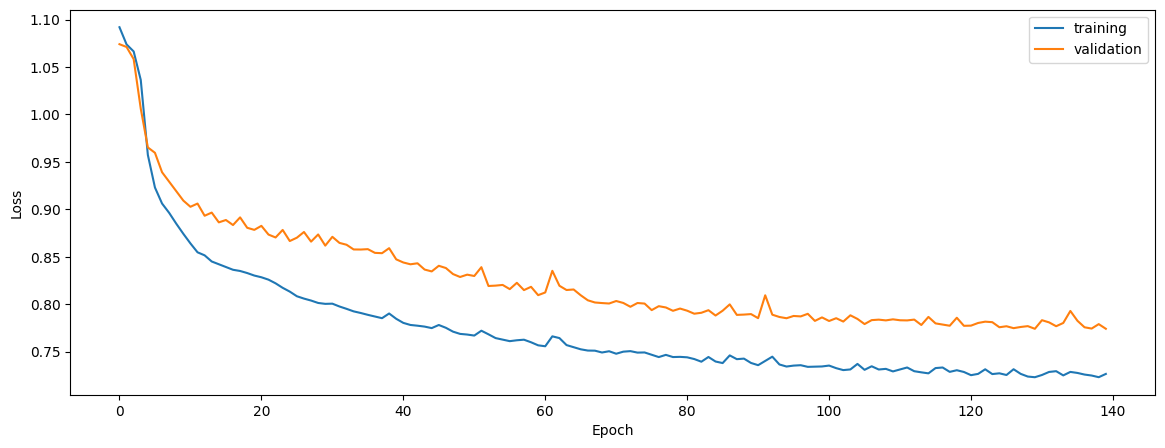

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASH))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.6729969635375804


0.6510805577322859


0.6663770936131768


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.7116837000853647


0.683528570455629


0.6973505199806305


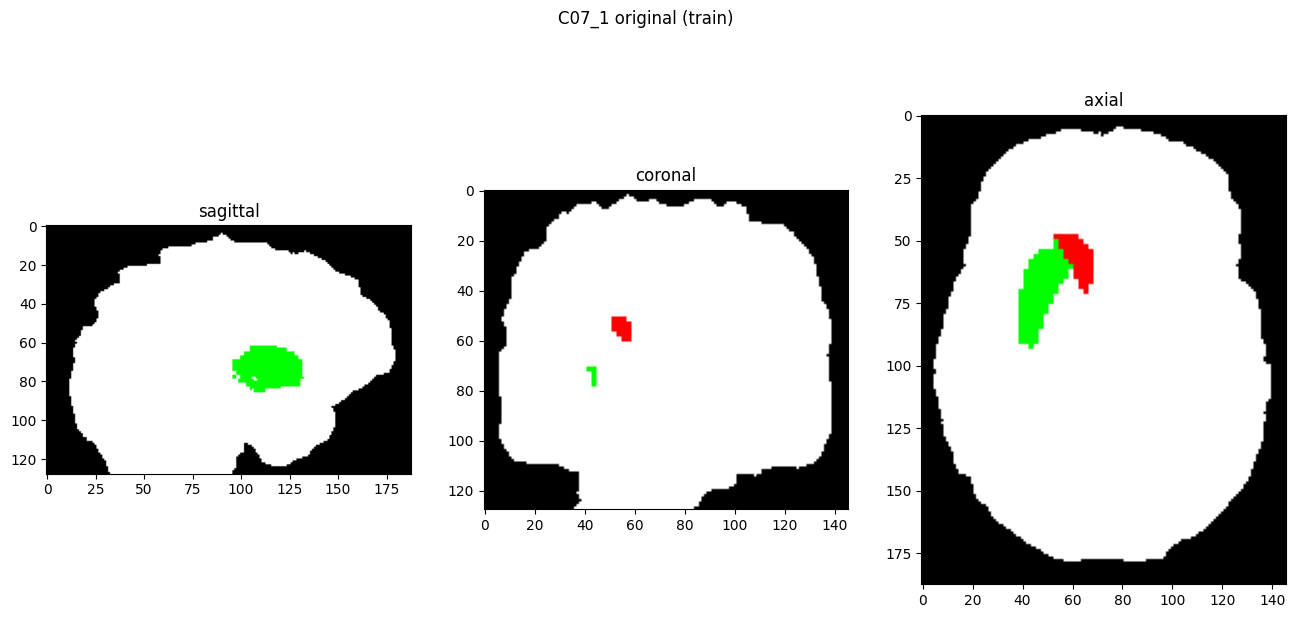

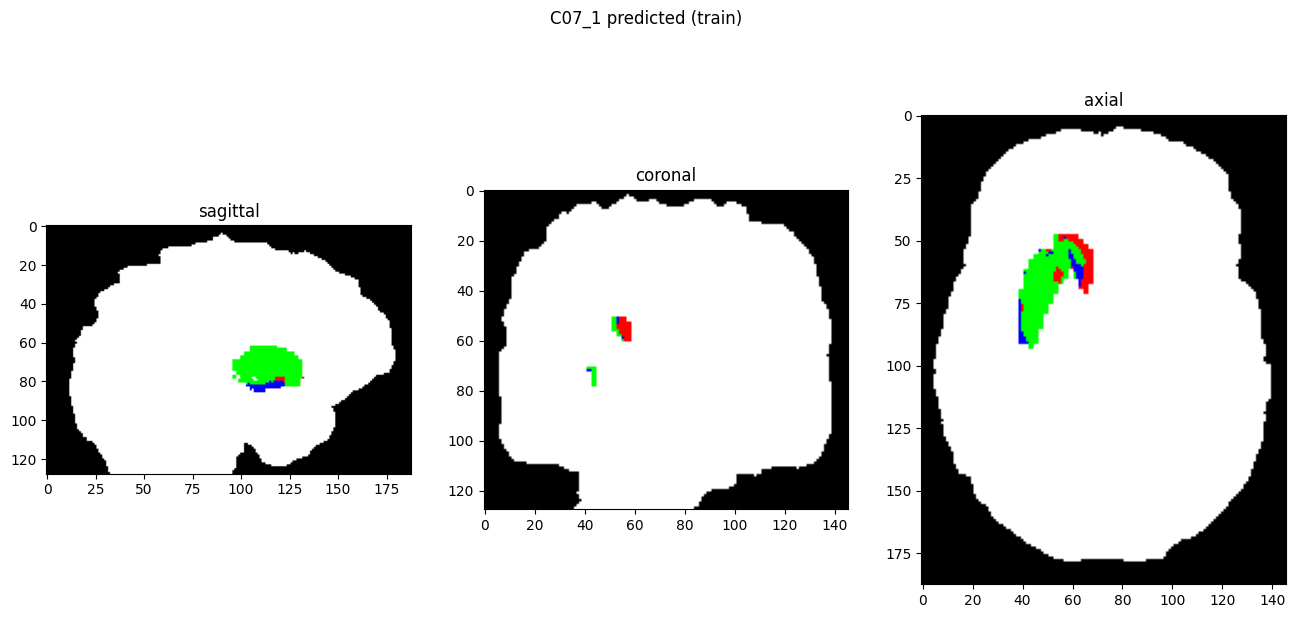

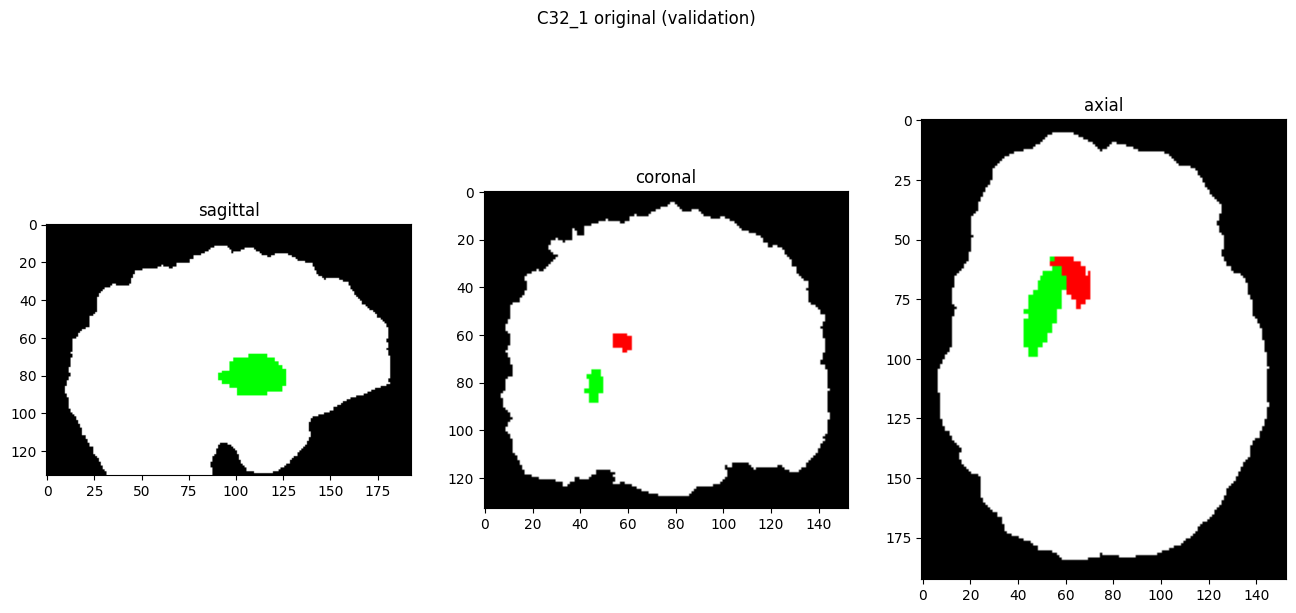

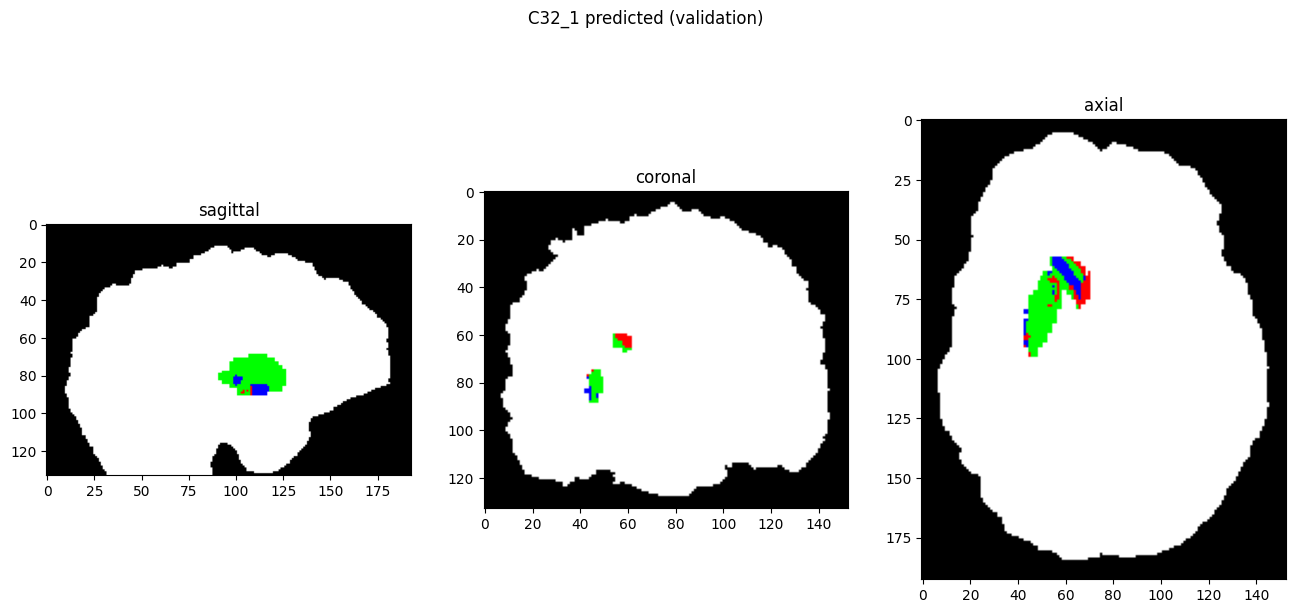

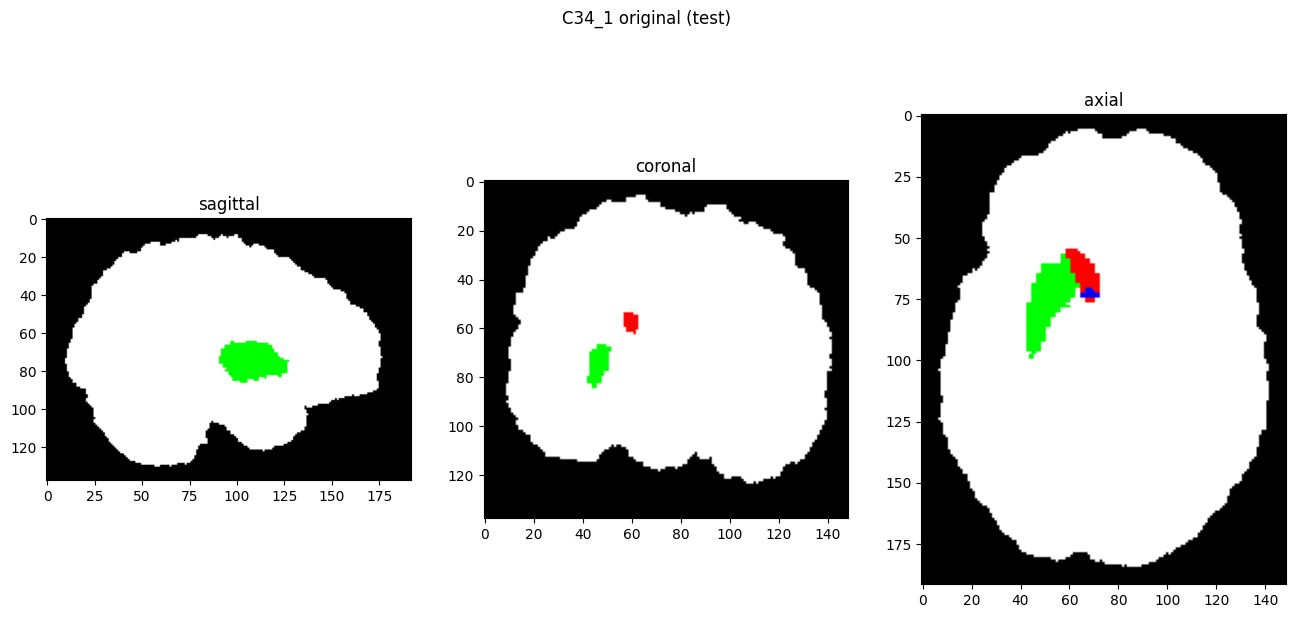

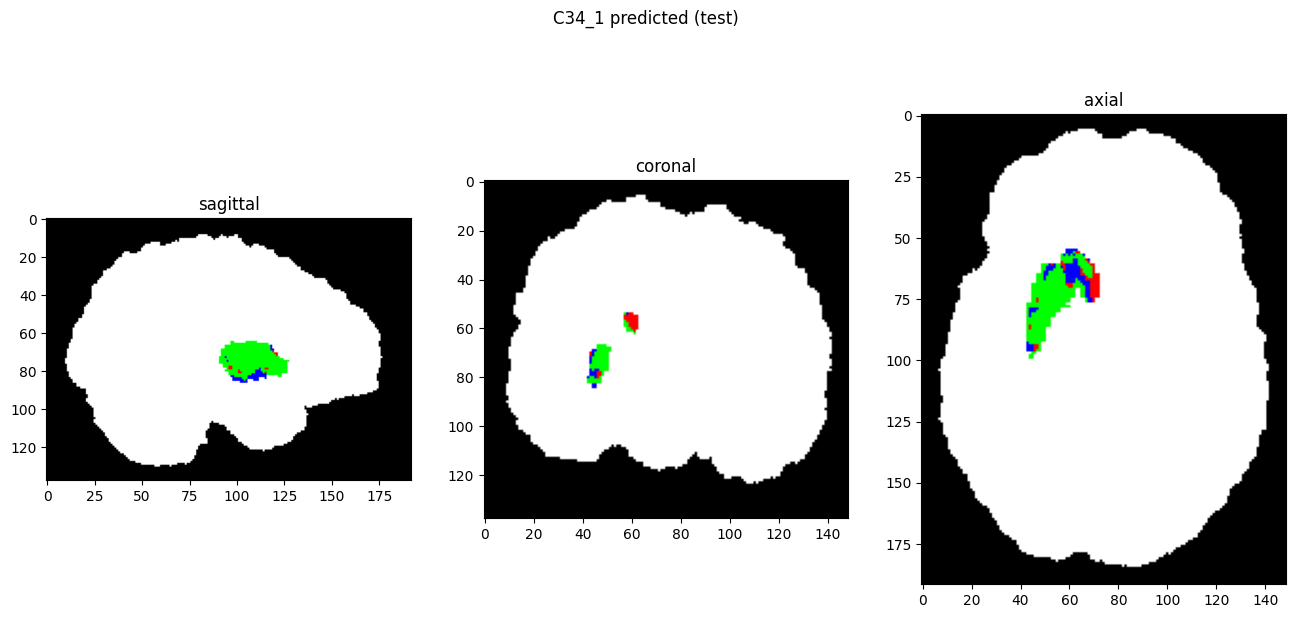

In [9]:
showResults(model, gen, threshold=0)